In [3]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
from matplotlib import colorbar
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from pickle import dump, load

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

np.random_state = 42

In [3]:
import umap

In [4]:
from bokeh.resources import INLINE


## Load In Dataset

In [4]:
sd_listings = pd.read_csv('data/sd_listings', index_col= 0)
sd_listings.head(3)

id                            listing_url  latitude   longitude  \
0  33159143  https://www.airbnb.com/rooms/33159143  32.91736  -117.07635   
1  17138468  https://www.airbnb.com/rooms/17138468  32.84067  -117.27443   
2  21898446  https://www.airbnb.com/rooms/21898446  32.79797   -117.2425   

   zipcode                                              name  \
0  92131.0  PRIVATE ROOM, SAFE NEIGHBORHOOD IN SCRIPPS RANCH   
1  92037.0                                     NOT AVAILABLE   
2  92109.0                         Townhome in Pacific Beach   

                                             summary  \
0  80% of the house + yourCozy room ... in Scripp...   
1  AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...   
2  Hi! We are basically renting this master for a...   

                       space  \
0  Full bed, private bath...   
1                        NaN   
2                        NaN   

                                         description  \
0  80% of the house + yourCozy room ... in Scripp...   
1  AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...   
2  Hi! We are basically renting this master for a...   

                               neighborhood_overview  \
0  The neighborhood is a typical Southern Califor...   
1                                                NaN   
2                                                NaN   

                                               notes  \
0  Have alarm system if you choose to use... I wi...   
1                                                NaN   
2                                                NaN   

                                             transit  \
0  You can park in the drive way or plenty of spa...   
1                                                NaN   
2                                                NaN   

                                              access  \
0  Kitchen, Dining room, Living room, Very Comfor...   
1                                                NaN   
2                                                NaN   

                                         interaction house_rules  \
0  I lived in San Diego 40+ years, love to share ...      #NAME?   
1                                                NaN         NaN   
2                                                NaN         NaN   

  property_type        room_type  accommodates  bathrooms bedrooms  beds  \
0         House     Private room             1        1.0      1.0   1.0   
1     Apartment  Entire home/apt             1        2.0      2.0   3.0   
2     Townhouse     Private room             1        1.0      1.0   1.0   

   bed_type                                          amenities  nightly_price  \
0  Real Bed  {Wifi,Kitchen,"Free parking on premises",Heati...         1100.0   
1  Real Bed  {TV,Wifi,"Air conditioning",Kitchen,"Free park...         1400.0   
2  Real Bed  {TV,Wifi,Kitchen,"Free parking on premises","P...         1250.0   

   price_per_stay  security_deposit  cleaning_fee  guests_included  \
0          1100.0            1000.0           0.0              1.0   
1          1400.0               NaN           NaN              1.0   
2          1250.0               NaN           NaN              1.0   

   extra_people  minimum_nights  maximum_nights      host_id  \
0           0.0            60.0            90.0  249661563.0   
1           0.0            30.0          1125.0   79755951.0   
2           0.0            30.0            30.0  159773487.0   

                                      host_url host_since  \
0  https://www.airbnb.com/users/show/249661563    3/18/19   
1   https://www.airbnb.com/users/show/79755951    6/24/16   
2  https://www.airbnb.com/users/show/159773487   11/22/17   

                                          host_about  host_response_time  \
0  Retired businessman of 30 years in this commun...  within a few hours   
1                             Quiet and considerate.                 NaN   
2                                                NaN  

## Select columns for modeling

In [5]:
sd_listings.columns

Index(['id', 'listing_url', 'latitude', 'longitude', 'zipcode', 'name',
       'summary', 'space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'nightly_price', 'price_per_stay',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'host_id', 'host_url', 'host_since',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'neighbourhood_cleansed',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'number_of_reviews', 'number_of_stays',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license',

In [6]:
modeling_cols = ['id', 'listing_url', 'latitude', 'longitude', 'neighbourhood_cleansed',
               'zipcode', 'property_type', 'room_type', 'accommodates', 
               'bathrooms', 'bedrooms', 'beds',
               'bed_type','nightly_price', 'price_per_stay',
               'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
               'minimum_nights', 'maximum_nights','host_response_time', 'host_response_rate',
               'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic',
               'host_identity_verified', 'number_of_reviews', 'number_of_stays',
               'review_scores_rating', 'review_scores_accuracy',
               'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location',
               'review_scores_value', 'requires_license', 'instant_bookable',
               'is_business_travel_ready', 'cancellation_policy',
               'require_guest_profile_picture', 'require_guest_phone_verification']

In [7]:
sd_modeling = sd_listings[modeling_cols]
sd_modeling.tail(2)

id                            listing_url  latitude   longitude  \
13049  17975942  https://www.airbnb.com/rooms/17975942  32.83598  -117.27878   
13050  33160513  https://www.airbnb.com/rooms/33160513  32.74357  -117.17679   

      neighbourhood_cleansed  zipcode property_type        room_type  \
13049               La Jolla  92037.0         House  Entire home/apt   
13050                Midtown  92103.0   Condominium  Entire home/apt   

       accommodates  bathrooms bedrooms  beds  bed_type  nightly_price  \
13049            21        5.5      7.0  13.0  Real Bed         1305.0   
13050            24        8.0      8.0  10.0  Real Bed          398.0   

       price_per_stay  security_deposit  cleaning_fee  guests_included  \
13049          1305.0            1000.0         800.0             21.0   
13050           398.0             500.0         499.0             24.0   

       extra_people  minimum_nights  maximum_nights host_response_time  \
13049           0.0             1.0          1125.0     within an hour   
13050           0.0             1.0           365.0     within an hour   

       host_response_rate  host_is_superhost  host_total_listings_count  \
13049                99.0                0.0                      403.0   
13050               100.0                1.0                      123.0   

       host_has_profile_pic  host_identity_verified  number_of_reviews  \
13049                   1.0                     0.0                4.0   
13050                   1.0                     0.0                1.0   

       number_of_stays  review_scores_rating  review_scores_accuracy  \
13049              8.0                  80.0                     9.0   
13050              2.0                  80.0                    10.0   

       review_scores_cleanliness  review_scores_checkin  \
13049                        8.0                   10.0   
13050                       10.0                    6.0   

       review_scores_communication  review_scores_location  \
13049                          8.0                    10.0   
13050                         10.0                    10.0   

       review_scores_value  requires_license  instant_bookable  \
13049                  9.0               0.0               1.0   
13050                  8.0               0.0               1.0   

       is_business_travel_ready cancellation_policy  \
13049                       0.0     super_strict_60   
13050                       0.0     super_strict_60   

       require_guest_profile_picture  require_guest_phone_verification  
13049                            0.0                               0.0  
13050                            0.0                               0.0

## Handle remaining missing values

In [8]:
# check missing
sd_modeling.isna().sum()

id                                     0
listing_url                            0
latitude                               0
longitude                              0
neighbourhood_cleansed                 2
zipcode                                0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                              3
bedrooms                               3
beds                                   9
bed_type                               0
nightly_price                          1
price_per_stay                         1
security_deposit                    2675
cleaning_fee                        1505
guests_included                        1
extra_people                           1
minimum_nights                         1
maximum_nights                         1
host_response_time                  2146
host_response_rate                     2
host_is_superhost                      2
host_total_listi

### Imputing missing `beds`

In [9]:
# fill missing beds with values in bedrooms
sd_modeling['beds'] = sd_modeling['beds'].fillna(sd_modeling['bedrooms'])

### Fill in missing `security_deposit`, `cleaning_fee` with 0's

In [10]:
sd_modeling[['security_deposit', 'cleaning_fee']] = sd_modeling[['security_deposit', 'cleaning_fee']].fillna(0)

### Impute missing values in `host_response_time`

In [11]:
# assign a new value 'no response' for the missing values
sd_modeling['host_response_time'] = sd_modeling['host_response_time'].fillna('no response')

In [12]:
sd_modeling['host_response_time'].value_counts()

host_response_time
within an hour        8410
no response           2146
within a few hours    1587
within a day           762
a few days or more     147
Name: count, dtype: int64

### Drop remaining rows with missing values
ie. Values that cannot be imputed because of nature of the feature

In [13]:
# Drop rows that has NaN values on selected columns
sd_modeling = sd_modeling.dropna()

In [14]:
sd_modeling.isna().sum()

id                                  0
listing_url                         0
latitude                            0
longitude                           0
neighbourhood_cleansed              0
zipcode                             0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
nightly_price                       0
price_per_stay                      0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
host_response_time                  0
host_response_rate                  0
host_is_superhost                   0
host_total_listings_count           0
host_has_profile_pic                0
host_identit

### Check of data-types after cleaning

In [15]:
# convert to appropriate datatype
sd_modeling['bedrooms'] = sd_modeling['bedrooms'].astype(float)
sd_modeling['zipcode'] = sd_modeling['zipcode'].astype(int)
sd_modeling['latitude'] = sd_modeling['latitude'].astype(float)
sd_modeling['longitude'] = sd_modeling['longitude'].astype(float)
sd_modeling['beds'] = sd_modeling['beds'].astype(float).astype(int)
sd_modeling['id'] = sd_modeling['id'].astype(int)

In [16]:
sd_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13039 entries, 0 to 13050
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13039 non-null  int64  
 1   listing_url                       13039 non-null  object 
 2   latitude                          13039 non-null  float64
 3   longitude                         13039 non-null  float64
 4   neighbourhood_cleansed            13039 non-null  object 
 5   zipcode                           13039 non-null  int64  
 6   property_type                     13039 non-null  object 
 7   room_type                         13039 non-null  object 
 8   accommodates                      13039 non-null  int64  
 9   bathrooms                         13039 non-null  float64
 10  bedrooms                          13039 non-null  float64
 11  beds                              13039 non-null  int64  
 12  bed_type 

In [17]:
sd_modeling.describe()

id      latitude     longitude        zipcode  accommodates  \
count  1.303900e+04  13039.000000  13039.000000   13039.000000  13039.000000   
mean   2.137590e+07     32.768303   -117.180228   92119.115960      4.467290   
std    1.050725e+07      0.065390      0.064366    7464.077192      3.009442   
min    6.000000e+00     32.531040   -117.281990   22000.000000      1.000000   
25%    1.358989e+07     32.725275   -117.244430   92101.000000      2.000000   
50%    2.180361e+07     32.757190   -117.167080   92107.000000      4.000000   
75%    3.069301e+07     32.798055   -117.140265   92110.000000      6.000000   
max    3.786276e+07     33.086070   -116.926530  921096.000000     24.000000   

          bathrooms      bedrooms          beds  nightly_price  \
count  13039.000000  13039.000000  13039.000000   13039.000000   
mean       1.507976      1.638086      2.384232     223.760948   
std        0.905094      1.194889      1.900844     344.161583   
min        0.000000      0.000000      0.000000       0.000000   
25%        1.000000      1.000000      1.000000      85.000000   
50%        1.000000      1.000000      2.000000     140.000000   
75%        2.000000      2.000000      3.000000     250.000000   
max       27.500000     14.000000     25.000000   10000.000000   

       price_per_stay  security_deposit  cleaning_fee  guests_included  \
count    13039.000000      13039.000000  13039.000000     13039.000000   
mean       531.701204        269.598819     95.218038         2.307846   
std        938.535880        485.414417    104.694887         2.323148   
min          0.000000          0.000000      0.000000         1.000000   
25%        130.000000          0.000000     25.000000         1.000000   
50%        297.000000        100.000000     65.000000         1.000000   
75%        500.000000        400.000000    130.000000         2.000000   
max      15000.000000       5000.000000   1025.000000        24.000000   

       extra_people  minimum_nights  maximum_nights  host_response_rate  \
count  13039.000000    13039.000000    13039.000000        13039.000000   
mean      13.541376        4.748140      619.999080           80.840939   
std       27.613084       15.713361     1297.715385           37.332285   
min        0.000000        1.000000        1.000000            0.000000   
25%        0.000000        1.000000       29.000000           91.000000   
50%        0.000000        2.000000      999.000000          100.000000   
75%       20.000000        3.000000     1125.000000          100.000000   
max      300.000000      800.000000    99999.000000          100.000000   

       host_is_superhost  host_total_listings_count  host_has_profile_pic  \
count       13039.000000               13039.000000          13039.000000   
mean            0.368587                  42.851599              0.998543   
std             0.482440                 175.396613              0.038146   
min             0.000000                   0.000000              0.000000   
25%             0.000000                   1.000000              1.000000   
50%             0.000000                   2.000000              1.000000   
75%             1.000000                   9.000000              1.000000   
max             1.000000                1737.000000              1.000000   

       host_identity_verified  number_of_reviews  number_of_stays  \
count            13039.000000       13039.000000     13039.000000   
mean                 0.486234          34.881203        69.762405   
std                  0.499830          60.035711       120.071422   
min                  0.000000           0.000000         0.000000   
25%                  0.000000           2.000000         4.000000   
50%                  0.000000          10.000000        20.000000   
75%                  1.000000          41.000000        82.000000   
max                  1.000000         786.000000      1572.000000   

       review_scores_rating  review_scores

In [18]:
sd_modeling[sd_modeling['zipcode']==92307]

id                            listing_url  latitude  longitude  \
12935  34895037  https://www.airbnb.com/rooms/34895037  32.88529 -117.24642   

      neighbourhood_cleansed  zipcode property_type        room_type  \
12935           Torrey Pines    92307         House  Entire home/apt   

       accommodates  bathrooms  bedrooms  beds  bed_type  nightly_price  \
12935            16        8.0       8.0     8  Real Bed         1518.0   

       price_per_stay  security_deposit  cleaning_fee  guests_included  \
12935          1518.0            1000.0         924.0             16.0   

       extra_people  minimum_nights  maximum_nights host_response_time  \
12935           0.0             1.0          1125.0     within an hour   

       host_response_rate  host_is_superhost  host_total_listings_count  \
12935                99.0                0.0                      403.0   

       host_has_profile_pic  host_identity_verified  number_of_reviews  \
12935                   1.0                     0.0                0.0   

       number_of_stays  review_scores_rating  review_scores_accuracy  \
12935              0.0                  97.0                    10.0   

       review_scores_cleanliness  review_scores_checkin  \
12935                       10.0                   10.0   

       review_scores_communication  review_scores_location  \
12935                         10.0                    10.0   

       review_scores_value  requires_license  instant_bookable  \
12935                 10.0               0.0               1.0   

       is_business_travel_ready cancellation_policy  \
12935                       0.0     super_strict_60   

       require_guest_profile_picture  require_guest_phone_verification  
12935                            0.0                               0.0

In [19]:
# save as csv
path = "data/"

sd_modeling.to_csv(path + 'sd_modeling_with_urls')

In [20]:
sd_modeling = sd_modeling.drop(columns = 'listing_url')
sd_modeling.head()

id  latitude  longitude neighbourhood_cleansed  zipcode  \
0  33159143  32.91736 -117.07635          Scripps Ranch    92131   
1  17138468  32.84067 -117.27443               La Jolla    92037   
2  21898446  32.79797 -117.24250          Pacific Beach    92109   
3  25948680  32.77545 -117.05923           College Area    92120   
4   1756516  32.84619 -117.27558               La Jolla    92037   

  property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0         House     Private room             1        1.0       1.0     1   
1     Apartment  Entire home/apt             1        2.0       2.0     3   
2     Townhouse     Private room             1        1.0       1.0     1   
3     Apartment  Entire home/apt             1        1.0       1.0     1   
4   Condominium     Private room             1        1.0       1.0     1   

   bed_type  nightly_price  price_per_stay  security_deposit  cleaning_fee  \
0  Real Bed         1100.0          1100.0            1000.0           0.0   
1  Real Bed         1400.0          1400.0               0.0           0.0   
2  Real Bed         1250.0          1250.0               0.0           0.0   
3  Real Bed         1150.0          1150.0               0.0           0.0   
4  Real Bed          110.0           110.0             200.0           0.0   

   guests_included  extra_people  minimum_nights  maximum_nights  \
0              1.0           0.0            60.0            90.0   
1              1.0           0.0            30.0          1125.0   
2              1.0           0.0            30.0            30.0   
3              1.0           0.0            31.0            40.0   
4              1.0          50.0           180.0           365.0   

   host_response_time  host_response_rate  host_is_superhost  \
0  within a few hours               100.0                0.0   
1         no response                 0.0                0.0   
2         no response                 0.0                0.0   
3         no response                 0.0                0.0   
4        within a day                67.0                0.0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                   1.0                     0.0   
1                        1.0                   1.0                     0.0   
2                        1.0                   1.0                     0.0   
3                        1.0                   1.0                     0.0   
4                        6.0                   1.0                     1.0   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                0.0              0.0                  98.0   
1                2.0              4.0                 100.0   
2                0.0              0.0                  97.0   
3                0.0              0.0                  98.0   
4                2.0              4.0                  90.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                     7.0                        7.0                    8.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                         10.0                    10.0                 10.0   
4                          8.0                     9.0                 10.0   

   requires_license  instant_bookable  is_business_travel_ready  \
0        

In [21]:
# save as csv
path = "data/"

sd_modeling.to_csv(path + 'sd_modeling_cleaned')

## Exploring Categorical Features

### Checking value counts for each categorical feature

In [22]:
cat_cols = sd_modeling.select_dtypes(include = ['object']).columns
cat_cols

Index(['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type',
       'host_response_time', 'cancellation_policy'],
      dtype='object')

In [23]:
for col in cat_cols:
    values = sd_modeling[col].value_counts()
    print(values, "\n")

neighbourhood_cleansed
Mission Bay        1589
Pacific Beach      1040
La Jolla            845
East Village        821
North Hills         737
                   ... 
Yosemite Dr           3
Horton Plaza          3
Eastlake Woods        2
Eastlake Trails       1
Thomy Locust Pl       1
Name: count, Length: 103, dtype: int64 

property_type
House                     4569
Apartment                 3391
Condominium               1990
Townhouse                  713
Guesthouse                 481
Guest suite                470
Bungalow                   298
Cottage                    289
Loft                       259
Villa                       88
Serviced apartment          83
Hostel                      72
Camper/RV                   57
Bed and breakfast           48
Other                       39
Resort                      35
Boat                        35
Tiny house                  29
Boutique hotel              26
Hotel                       15
Aparthotel                  12
Tent   

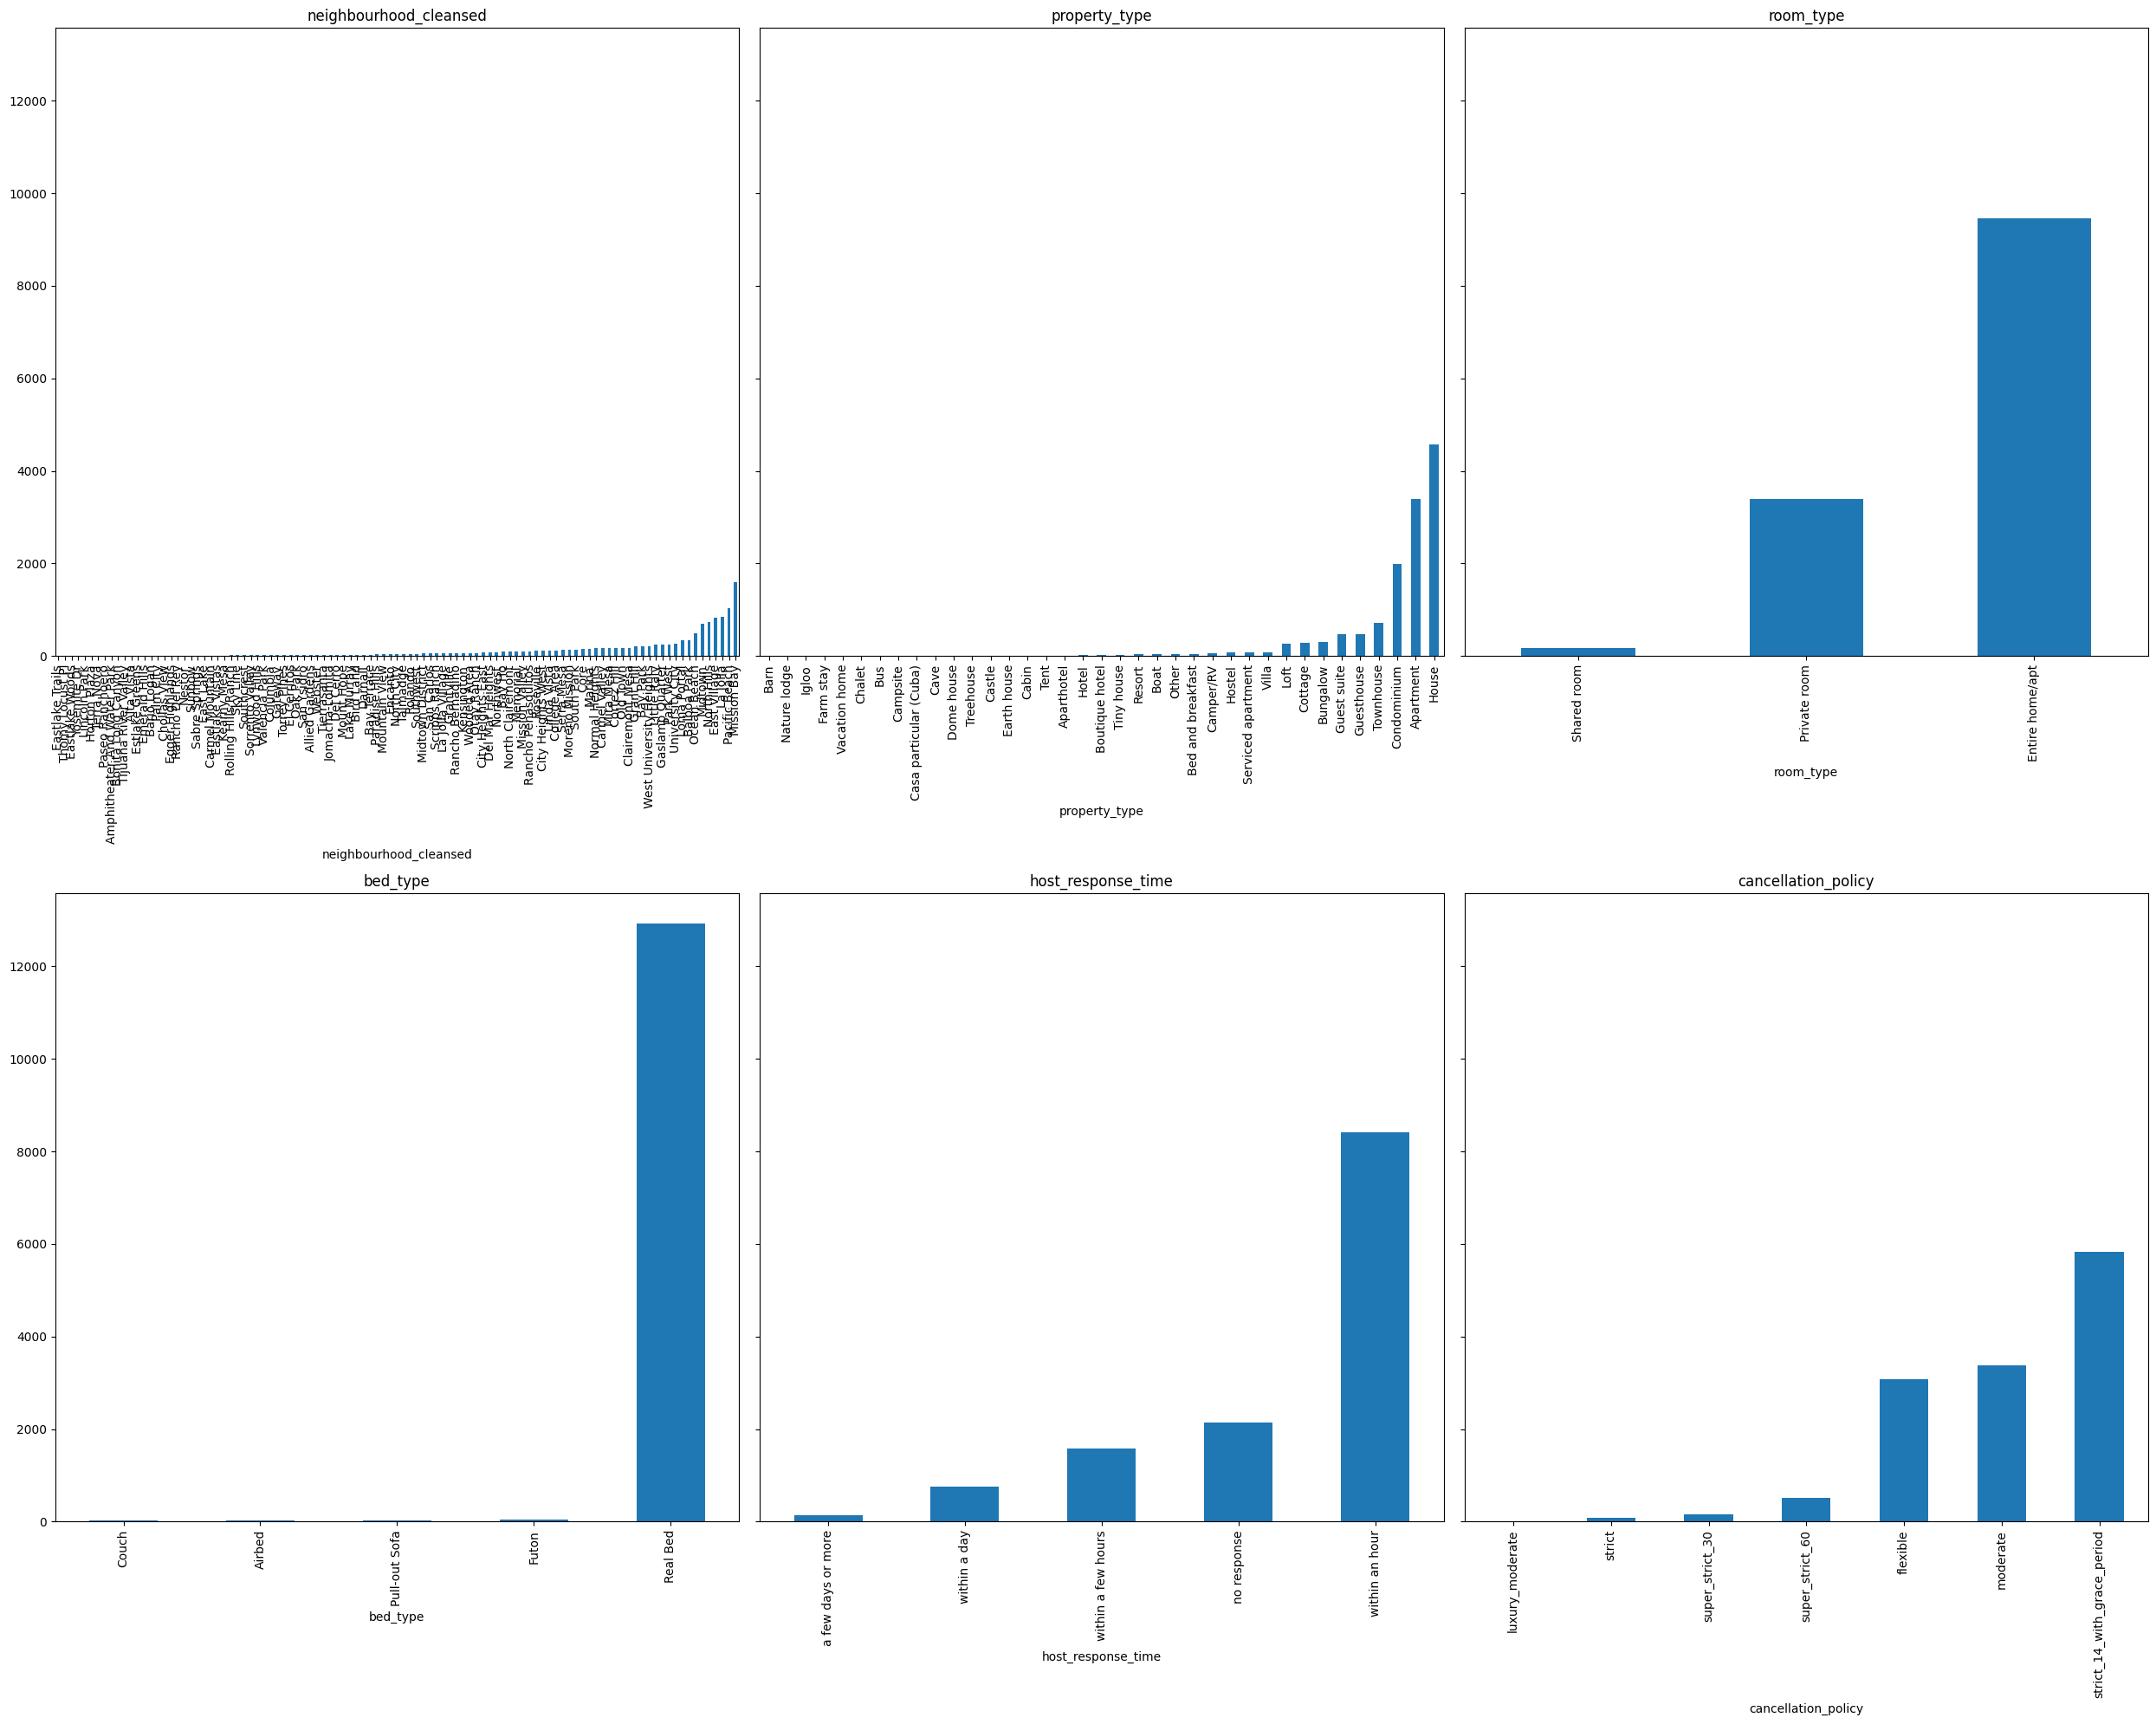

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharey=True)

# Create bar plots
cat_cols = list(cat_cols)

for col, ax in zip(cat_cols, axes.flatten()):
    (sd_modeling.groupby(col)        # group values together by column of interest
         .count()['nightly_price']    # take the mean of the nightly_price for each group
         .sort_values()              # sort the groups in ascending order
         .plot
         .bar(ax=ax))                # create a bar graph on the ax
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

### Distribution of numerical features

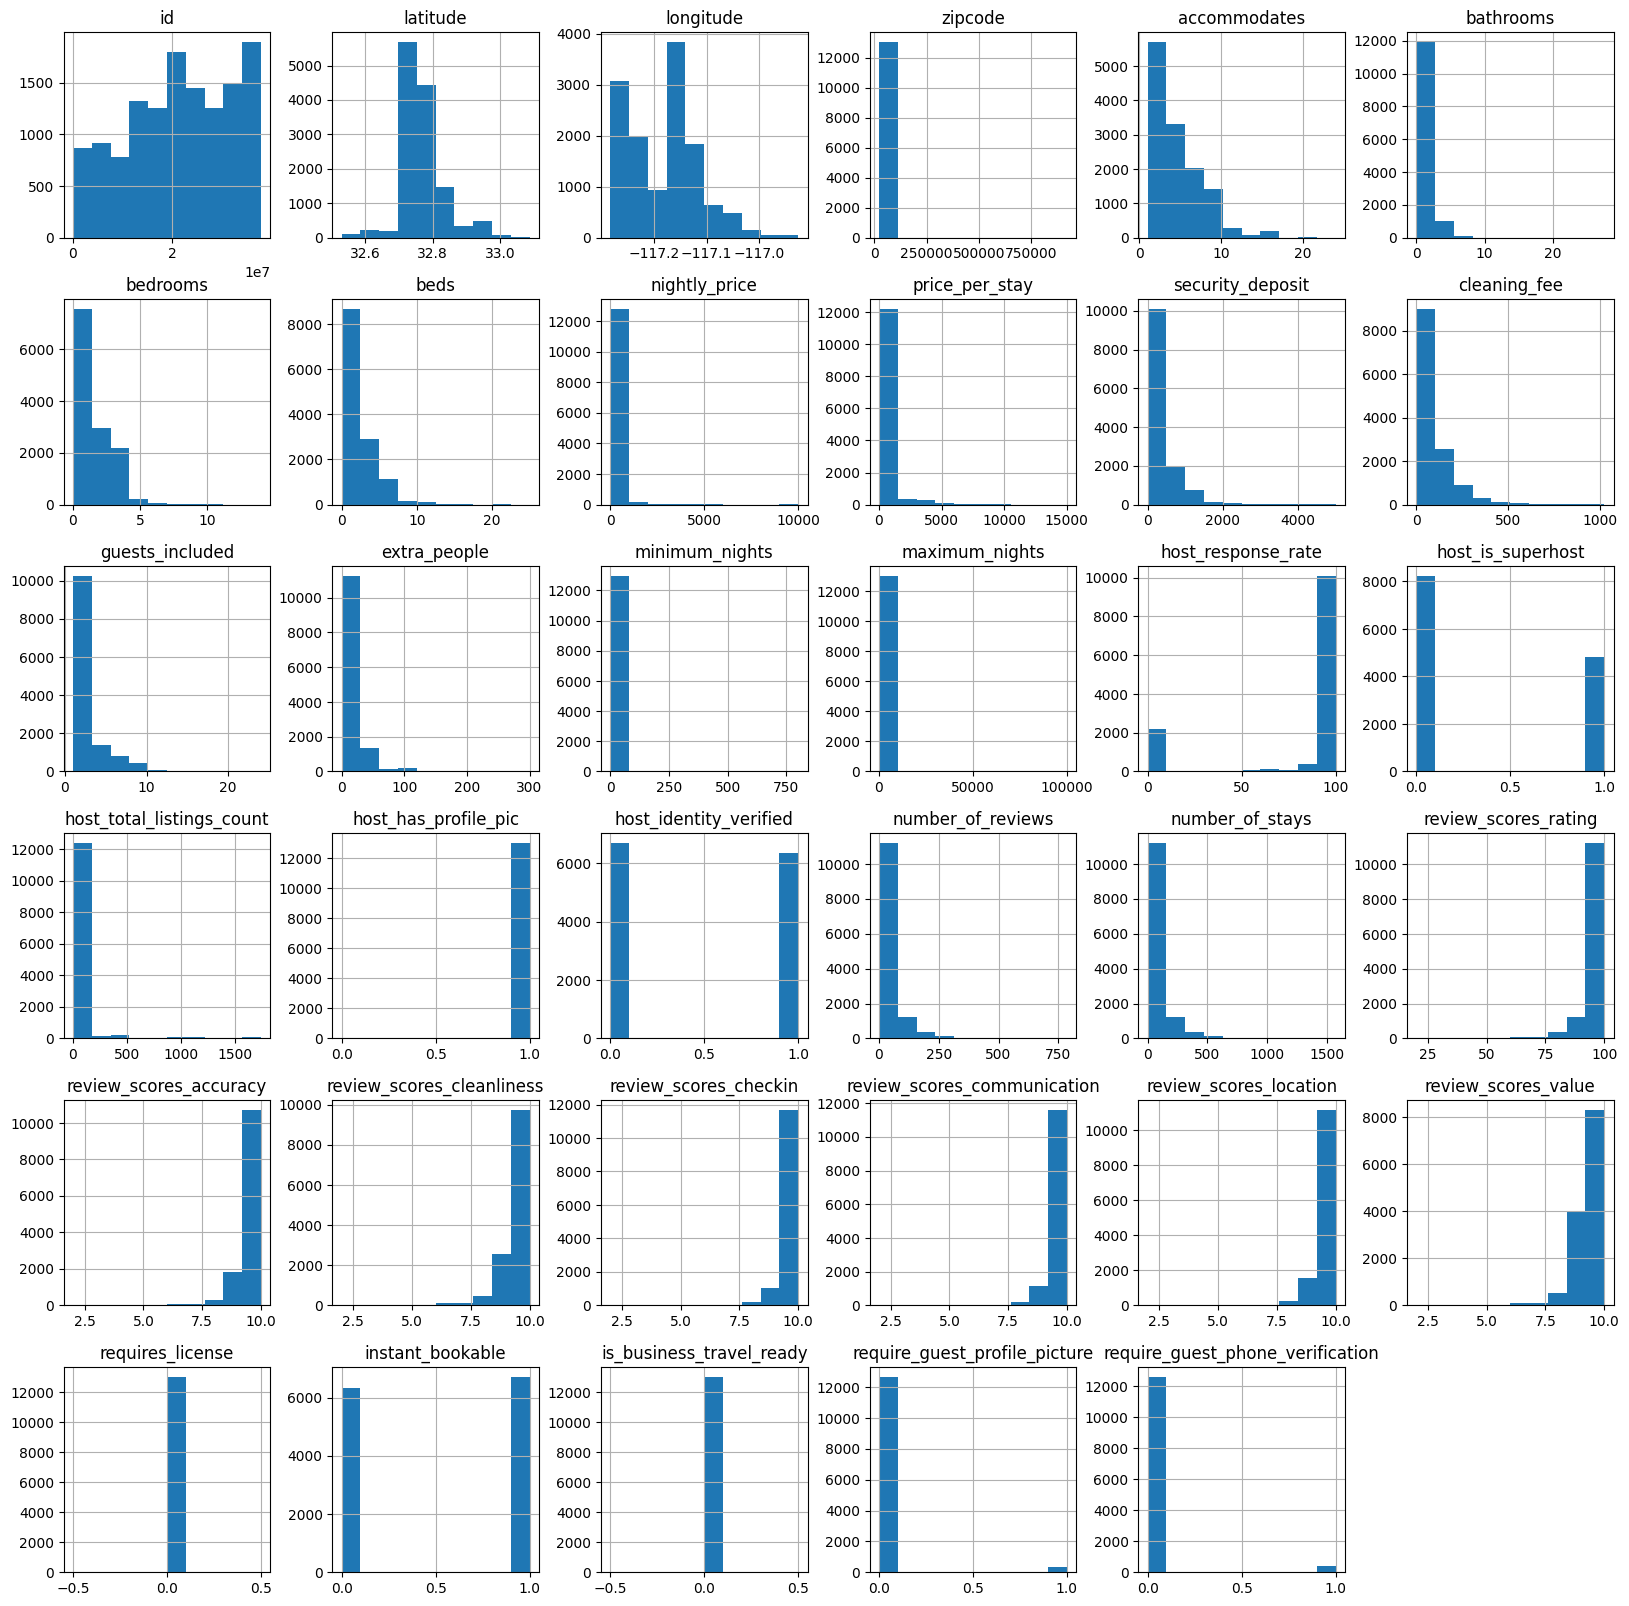

In [25]:
sd_modeling.hist(figsize = (20,20))
plt.show()

- Most numerical features have a long right tail (ie. right-skewed) and are not normally distributed. For example, the number of bedrooms is expected to have a long right tail as most people would likely want to find listings with less than 2 bedrooms. 

## Correlations Between Features

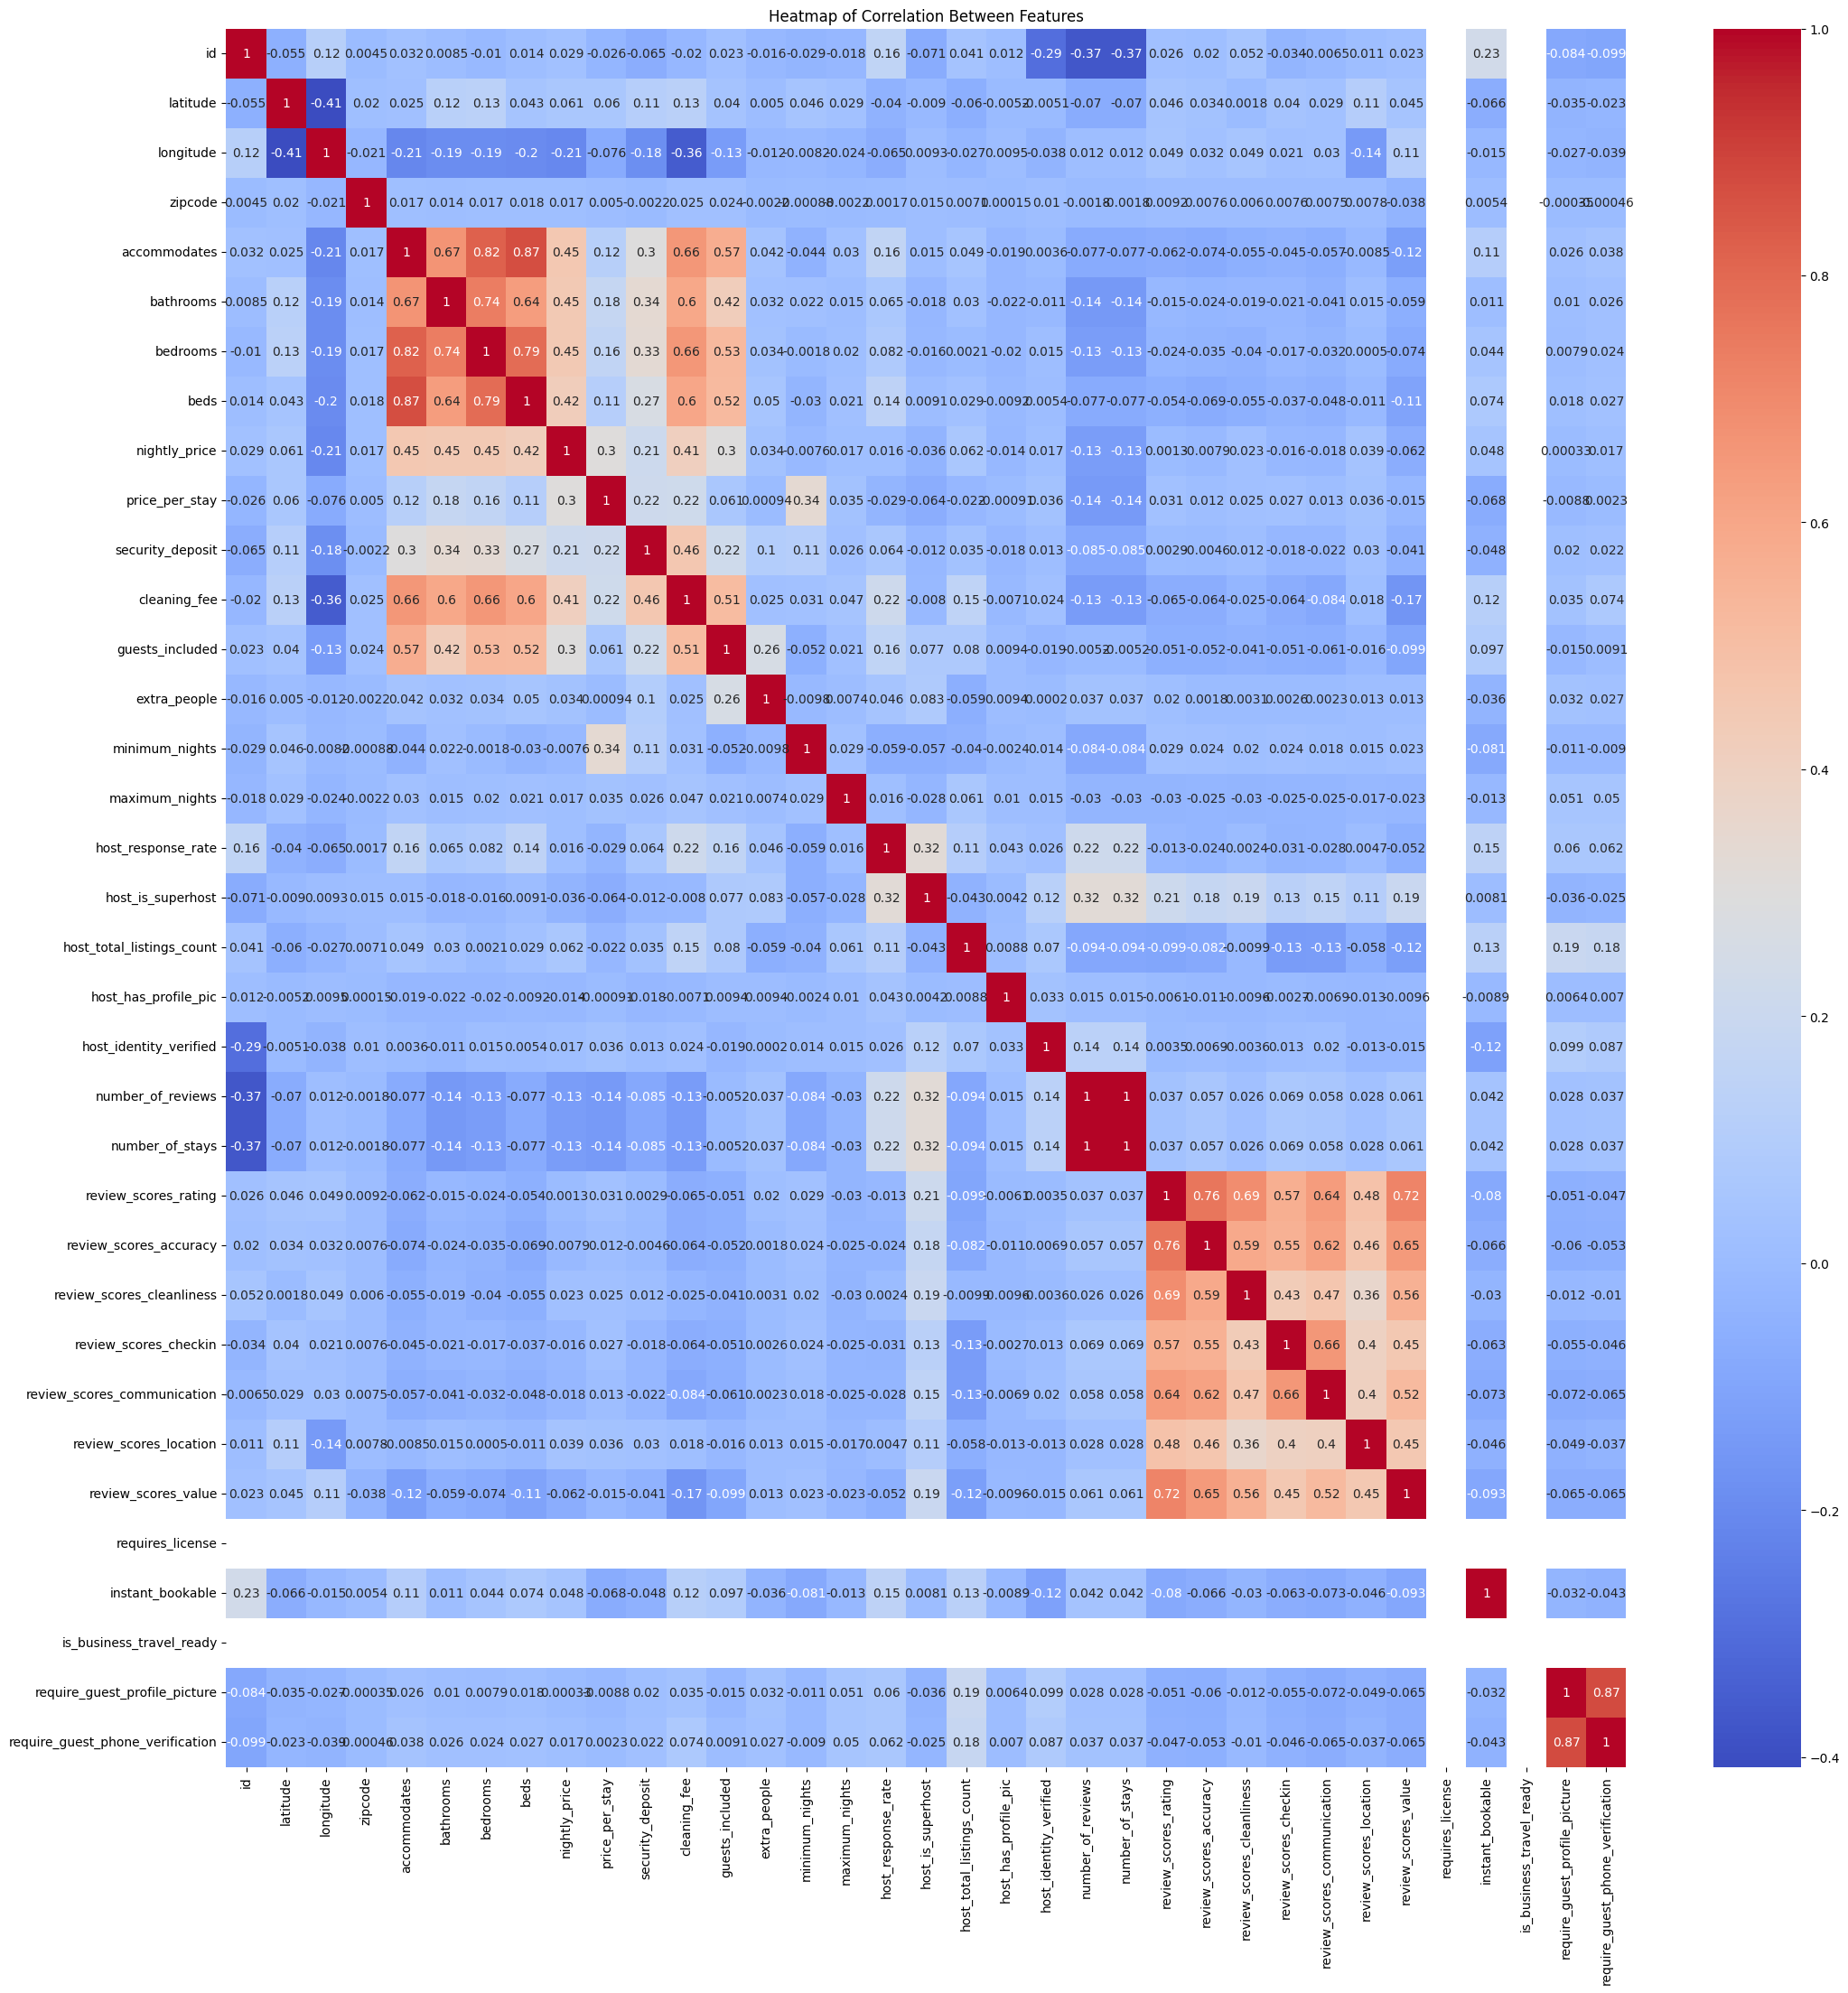

In [28]:
# Set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# Select only numeric columns from the DataFrame
numeric_columns = sd_modeling.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix for numeric columns
corr = numeric_columns.corr()

# Plot the heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Features")

# Show the plot
plt.show()


ValueError: could not convert string to float: 'Scripps Ranch'

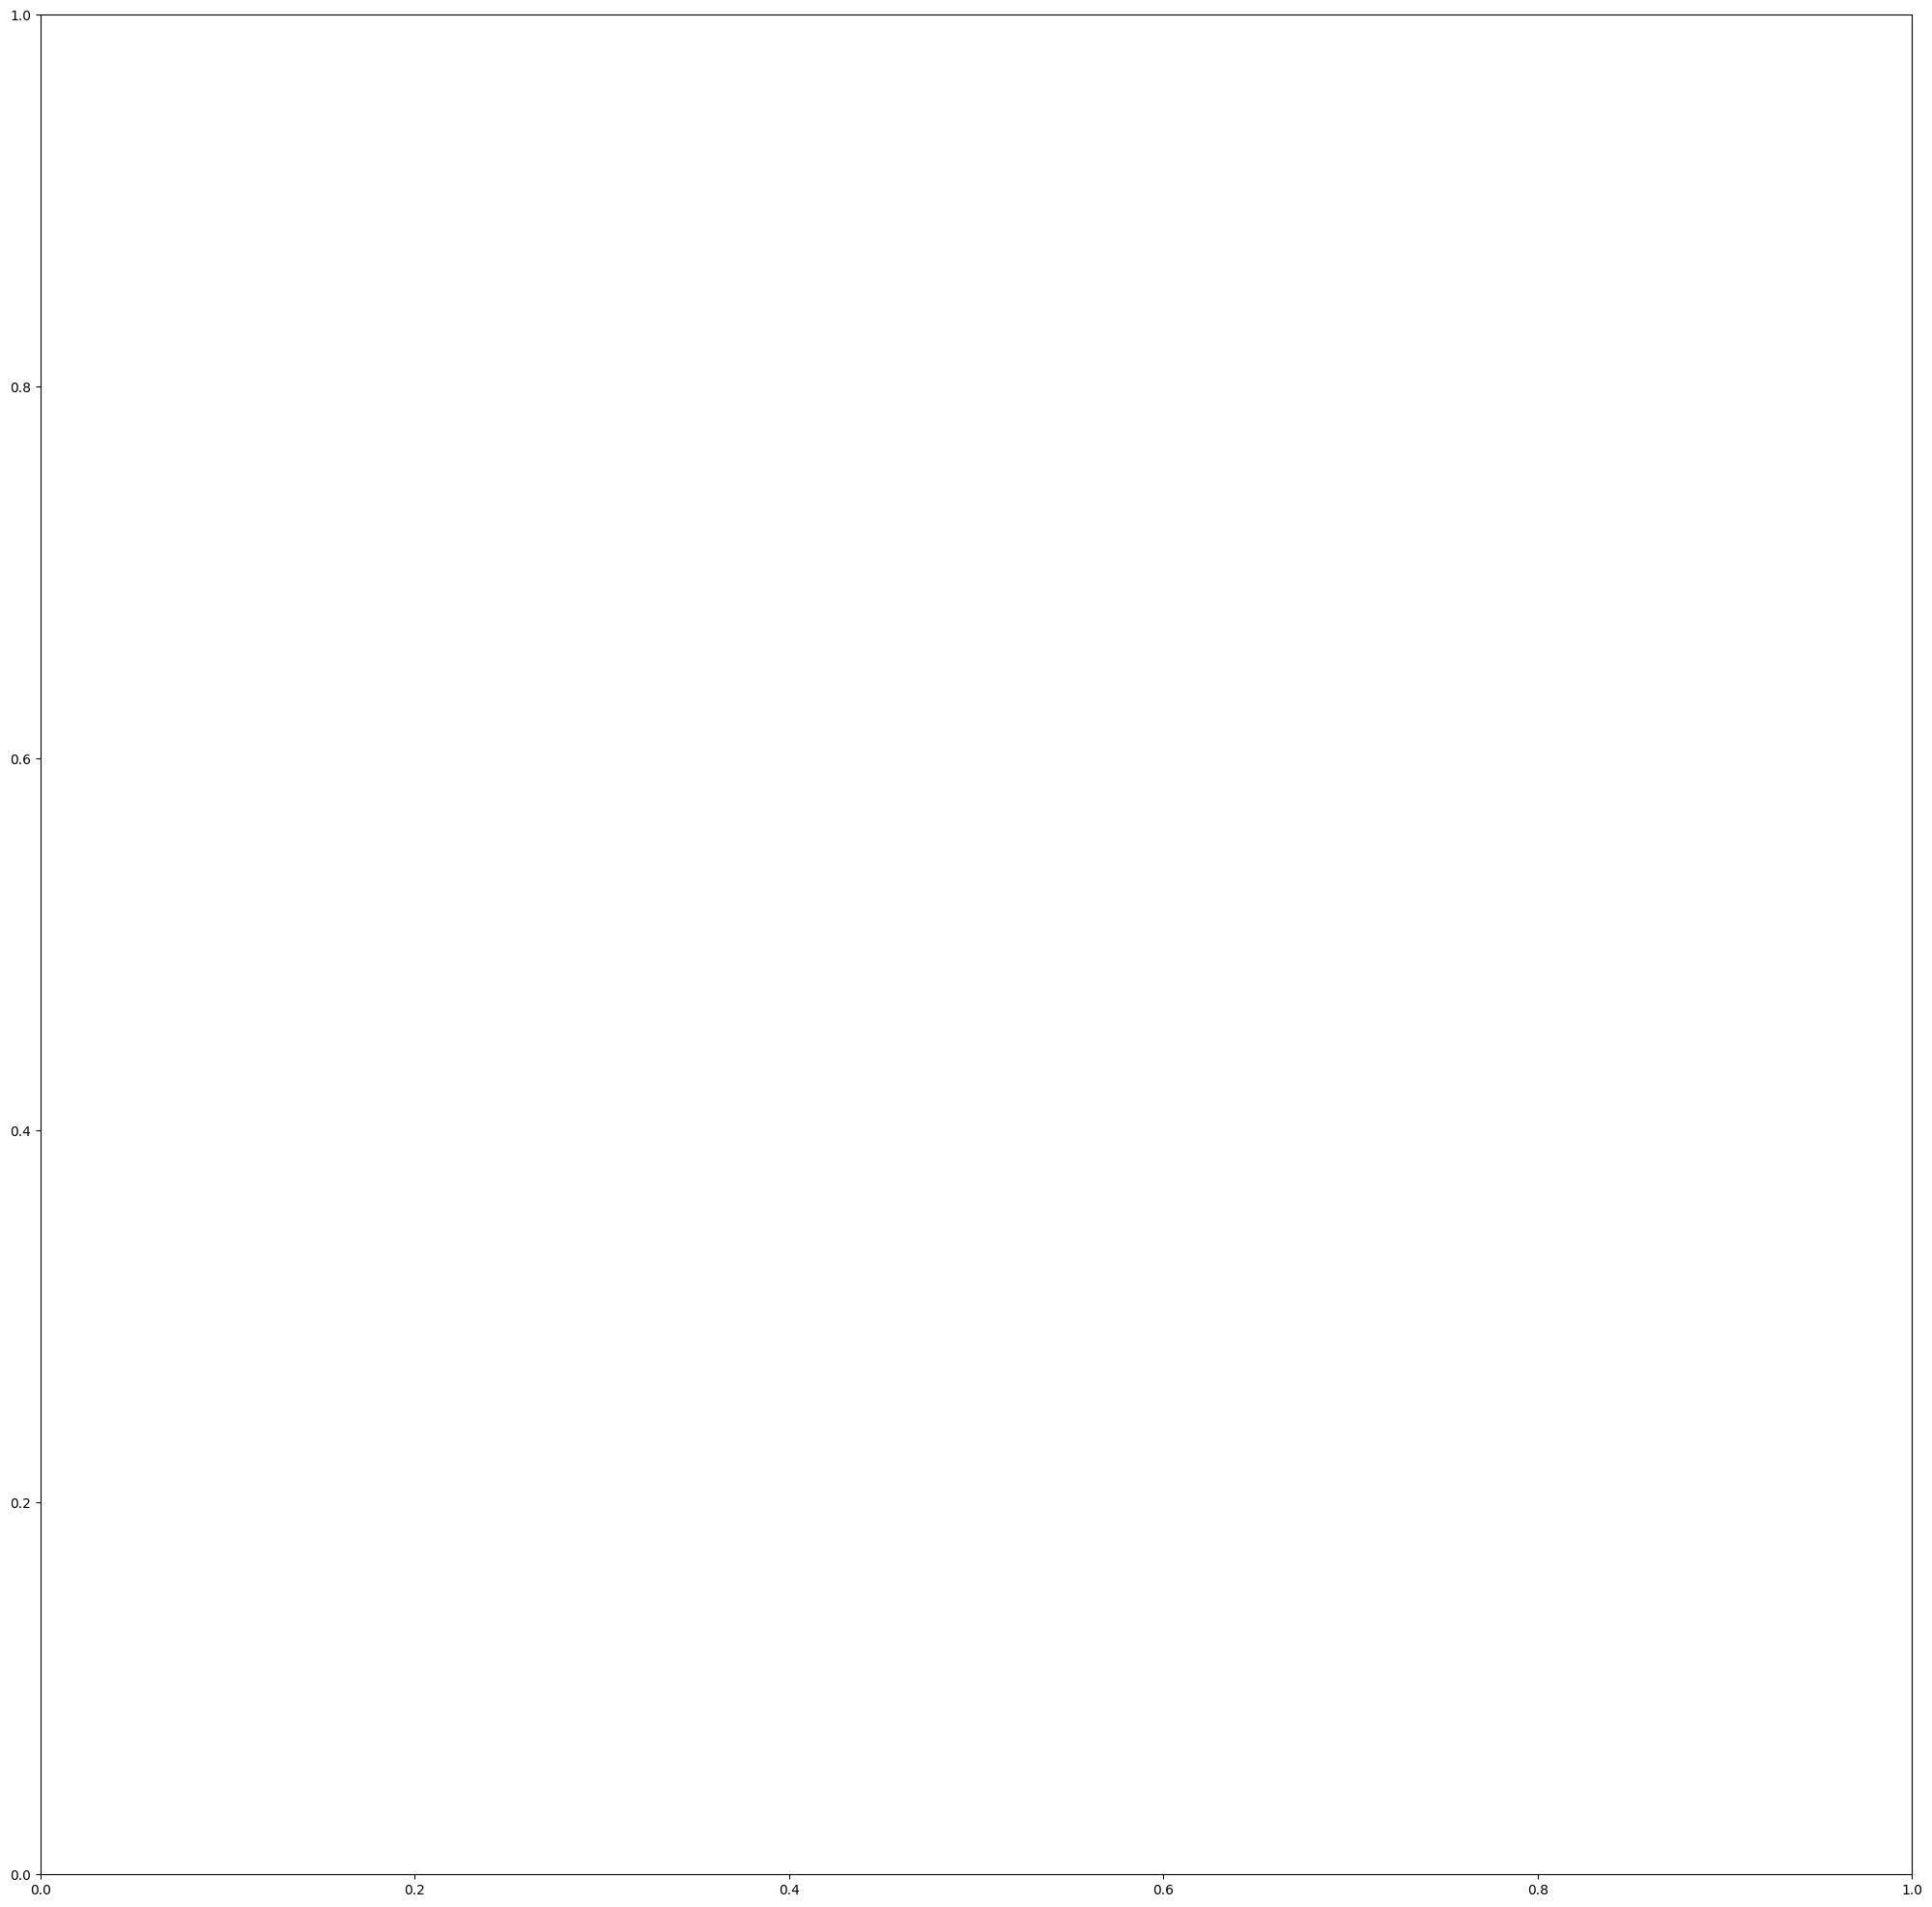

In [27]:
# set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# set up correlation matrix
corr = sd_modeling.corr()

sns.heatmap(corr, cmap = 'coolwarm', annot = True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Features");

plt.show()

- Strong correlational relationship bewteen number of beds, bathrooms, and bedrooms. These features also appear to be the strongest indicators of price ie. nightly price. 


- As expected, there are also correlations between review scores (rating, accuracy, cleanliness, etc.). 

## Preprocessing Features

### Categorical features

In [29]:
cat_cols

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'host_response_time',
 'cancellation_policy']

We'll also add `zipcode` as an nominal feature that needs to be OHE. 

In [30]:
# first convert zipcode to a dtype object for OHE
sd_modeling['zipcode'] = sd_modeling['zipcode'].astype(object)

#### Establish order of ordinal columns

In [31]:
# convert to categorical dtype
sd_modeling['host_response_time'] = sd_modeling['host_response_time'].astype('category')
sd_modeling['cancellation_policy'] = sd_modeling['cancellation_policy'].astype('category')

In [32]:
# define order of the ordinal features
response_time_list = ['within an hour',
                      'within a few hours', 
                      'within a day', 
                      'a few days or more', 
                      'no response']

cancellation_policy_list = ['flexible',
                            'moderate',
                            'strict',
                            'strict_14_with_grace_period', 
                            'super_strict_60', 
                            'super_strict_30',
                            'luxury_moderate']

In [33]:
# define nominal and ordinal features in the categorical columns
nom_cols = sd_modeling.select_dtypes(['object']).columns
print(nom_cols)
ordinal_cols = sd_modeling.select_dtypes(['category']).columns
print(ordinal_cols)

Index(['neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type',
       'bed_type'],
      dtype='object')
Index(['host_response_time', 'cancellation_policy'], dtype='object')


For more information on the ordinal ranking of `cancellation_policy`; refer to <a href = 'https://www.airbnb.com/help/article/475/cancellation-policies-for-your-listing'> Airbnb's cancellation policies</a>.

### Building pipeline transformer

In [34]:
# define numeric transformation pipeline that scales the numbers
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) 

# define an ordinal transformation pipeline that ordinal encodes the cats
ordinal_pipeline = Pipeline([('ordinalenc', OrdinalEncoder(categories = [response_time_list, 
                                                                         cancellation_policy_list]))])

# define a nominal transformation pipeline that OHE the cats
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories= "auto", 
                                                         sparse = False, 
                                                         handle_unknown = 'ignore'))]) 

Define new dataset to be preprocessed:

In [35]:
sd_trans = sd_modeling.drop(columns = ['id', 'latitude', 'longitude'])
sd_trans = sd_trans.reset_index(drop = 'index')
sd_trans.head()

neighbourhood_cleansed zipcode property_type        room_type  accommodates  \
0          Scripps Ranch   92131         House     Private room             1   
1               La Jolla   92037     Apartment  Entire home/apt             1   
2          Pacific Beach   92109     Townhouse     Private room             1   
3           College Area   92120     Apartment  Entire home/apt             1   
4               La Jolla   92037   Condominium     Private room             1   

   bathrooms  bedrooms  beds  bed_type  nightly_price  price_per_stay  \
0        1.0       1.0     1  Real Bed         1100.0          1100.0   
1        2.0       2.0     3  Real Bed         1400.0          1400.0   
2        1.0       1.0     1  Real Bed         1250.0          1250.0   
3        1.0       1.0     1  Real Bed         1150.0          1150.0   
4        1.0       1.0     1  Real Bed          110.0           110.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0            1000.0           0.0              1.0           0.0   
1               0.0           0.0              1.0           0.0   
2               0.0           0.0              1.0           0.0   
3               0.0           0.0              1.0           0.0   
4             200.0           0.0              1.0          50.0   

   minimum_nights  maximum_nights  host_response_time  host_response_rate  \
0            60.0            90.0  within a few hours               100.0   
1            30.0          1125.0         no response                 0.0   
2            30.0            30.0         no response                 0.0   
3            31.0            40.0         no response                 0.0   
4           180.0           365.0        within a day                67.0   

   host_is_superhost  host_total_listings_count  host_has_profile_pic  \
0                0.0                        1.0                   1.0   
1                0.0                        1.0                   1.0   
2                0.0                        1.0                   1.0   
3                0.0                        1.0                   1.0   
4                0.0                        6.0                   1.0   

   host_identity_verified  number_of_reviews  number_of_stays  \
0                     0.0                0.0              0.0   
1                     0.0                2.0              4.0   
2                     0.0                0.0              0.0   
3                     0.0                0.0              0.0   
4                     1.0                2.0              4.0   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  98.0                    10.0                       10.0   
1                 100.0                    10.0                       10.0   
2                  97.0                    10.0                       10.0   
3                  98.0                    10.0                       10.0   
4                  90.0                     7.0                        7.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                   10.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   
3                   10.0                         10.0                    10.0   
4                    8.0                          8.0                     9.0   

   review_scores_value  requires_license  instant_bookable  \
0                 10.0               0.0               1.0   
1                 10.0               0.0               1.0   
2                 10.0               0.0               1.0   
3                 10.0               0.0               0.0   
4                 10.0               0.0               0.0   

   is_business_travel_ready          cancella

In [36]:
# construct column transformer for the selected columns with pipelines
ct = ColumnTransformer(transformers = [("nominalpipe", nominal_pipeline, ['neighbourhood_cleansed',
                                                                            'zipcode', 'property_type', 
                                                                            'room_type','bed_type']),
                                       ("ordinalpipe", ordinal_pipeline, ['host_response_time', 
                                                                          'cancellation_policy']),
                                       ("numericpipe", numeric_pipeline, sd_trans.select_dtypes(['int', 'float']).columns)])

In [40]:
# save the column transformer
dump(ct, open('/Users/aryakbodkhe/Desktop/airbnb_recommendations-main/notebooks/column_transformer.pkl', 'wb'))

#### Reorder dataframe for simplicity of feature name retrieval

In [41]:
# reorder the df with nominal first, ordinal second, and remaining numeric last

sd_trans = sd_trans[ # nominal below this line
                    ['neighbourhood_cleansed','zipcode', 'property_type', 'room_type','bed_type',
                     # ordinal below this line
                     'host_response_time', 'cancellation_policy', 
                     # remaining numeric
                     'accommodates', 'bathrooms', 'bedrooms', 'beds','nightly_price', 'price_per_stay', 
                     'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights', 
                     'maximum_nights', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                     'host_has_profile_pic','host_identity_verified', 'number_of_reviews', 'number_of_stays', 'review_scores_rating', 
                     'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                     'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                     'requires_license', 'instant_bookable', 'is_business_travel_ready',
                     'require_guest_profile_picture', 'require_guest_phone_verification']]

In [42]:
sd_trans.head()

neighbourhood_cleansed zipcode property_type        room_type  bed_type  \
0          Scripps Ranch   92131         House     Private room  Real Bed   
1               La Jolla   92037     Apartment  Entire home/apt  Real Bed   
2          Pacific Beach   92109     Townhouse     Private room  Real Bed   
3           College Area   92120     Apartment  Entire home/apt  Real Bed   
4               La Jolla   92037   Condominium     Private room  Real Bed   

   host_response_time          cancellation_policy  accommodates  bathrooms  \
0  within a few hours  strict_14_with_grace_period             1        1.0   
1         no response  strict_14_with_grace_period             1        2.0   
2         no response                     flexible             1        1.0   
3         no response                     flexible             1        1.0   
4        within a day  strict_14_with_grace_period             1        1.0   

   bedrooms  beds  nightly_price  price_per_stay  security_deposit  \
0       1.0     1         1100.0          1100.0            1000.0   
1       2.0     3         1400.0          1400.0               0.0   
2       1.0     1         1250.0          1250.0               0.0   
3       1.0     1         1150.0          1150.0               0.0   
4       1.0     1          110.0           110.0             200.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0           0.0              1.0           0.0            60.0   
1           0.0              1.0           0.0            30.0   
2           0.0              1.0           0.0            30.0   
3           0.0              1.0           0.0            31.0   
4           0.0              1.0          50.0           180.0   

   maximum_nights  host_response_rate  host_is_superhost  \
0            90.0               100.0                0.0   
1          1125.0                 0.0                0.0   
2            30.0                 0.0                0.0   
3            40.0                 0.0                0.0   
4           365.0                67.0                0.0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                   1.0                     0.0   
1                        1.0                   1.0                     0.0   
2                        1.0                   1.0                     0.0   
3                        1.0                   1.0                     0.0   
4                        6.0                   1.0                     1.0   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                0.0              0.0                  98.0   
1                2.0              4.0                 100.0   
2                0.0              0.0                  97.0   
3                0.0              0.0                  98.0   
4                2.0              4.0                  90.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                     7.0                        7.0                    8.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                         10.0                    10.0                 10.0   
4                          8.0                     9.0                 10.0   

   requires_license  instant_bookable  is_business_travel_ready  \
0               0.0 

In [43]:
sd_trans.shape

(13039, 38)

In [44]:
# save as csv
path = "data/"

sd_trans.to_csv(path + 'sd_trans')

### Transforming 

In [45]:
sd_pp = pd.DataFrame(ct.fit_transform(sd_trans))

In [46]:
sd_pp.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   90   91   92   93   94   95   96   97   98   99   100  101  102  103  104  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

#### Get Feature Names and Assign to `sd_pp`

In [48]:
# Assuming 'nominal_pipeline' is your OneHotEncoder within a pipeline
nominal_encoder = nominal_pipeline.named_steps['onehotenc']

# Fit and transform the data with the encoder
transformed_data = nominal_encoder.fit_transform(sd_trans[nom_cols])

# Get feature names using get_feature_names_out
nominal_features = list(nominal_encoder.get_feature_names_out(nom_cols))

# Now nominal_features contains the feature names after one-hot encoding


In [47]:
# get nominal values
nominal_features = list(nominal_pipeline.named_steps['onehotenc'].fit(sd_trans[nom_cols]).get_feature_names())

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [49]:
nominal_features[0:5]

['neighbourhood_cleansed_Allied Gardens',
 'neighbourhood_cleansed_Alta Vista',
 'neighbourhood_cleansed_Amphitheater And Water Park',
 'neighbourhood_cleansed_Balboa Park',
 'neighbourhood_cleansed_Bario Logan']

##### Cleaning feature names

In [50]:
ordinal_list = list(ordinal_cols)
ordinal_list 

['host_response_time', 'cancellation_policy']

In [51]:
numeric_list = ['accommodates', 'bathrooms', 'bedrooms', 'beds','nightly_price', 'price_per_stay', 
                     'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights', 
                     'maximum_nights', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                     'host_has_profile_pic','host_identity_verified', 'number_of_reviews', 'number_of_stays', 'review_scores_rating', 
                     'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                     'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                     'requires_license', 'instant_bookable', 'is_business_travel_ready',
                     'require_guest_profile_picture', 'require_guest_phone_verification']
len(numeric_list)

31

In [52]:
features_to_clean = ['x0_Allied Gardens', 'x0_Alta Vista', 'x0_Amphitheater And Water Park', 'x0_Balboa Park',
                   'x0_Bario Logan', 'x0_Bay Ho', 'x0_Bay Park', 'x0_Bay Terrace', 'x0_Bird Land',
                   'x0_Bonita Long Canyon', 'x0_Carmel Mountain', 'x0_Carmel Valley', 'x0_Chollas View',
                   'x0_City Heights East', 'x0_City Heights West', 'x0_Clairemont Mesa', 'x0_College Area',
                   'x0_Columbia', 'x0_Core', 'x0_Cortez Hill', 'x0_Darnall', 'x0_Del Cerro',
                   'x0_Del Mar Heights', 'x0_East Lake', 'x0_East Village', 'x0_Eastlake Trails',
                   'x0_Eastlake Vistas', 'x0_Eastlake Woods', 'x0_Egger Highlands', 'x0_El Cerritos',
                   'x0_Emerald Hills', 'x0_Encanto', 'x0_Estlake Greens', 'x0_Gaslamp Quarter', 'x0_Gateway',
                   'x0_Grant Hill', 'x0_Grantville', 'x0_Horton Plaza', 'x0_Jomacha-Lomita', 'x0_Kearny Mesa',
                   'x0_Kensington', 'x0_La Jolla', 'x0_La Jolla Village', 'x0_Lake Murray', 'x0_Lincoln Park',
                   'x0_Linda Vista', 'x0_Little Italy', 'x0_Loma Portal', 'x0_Lynwood Hills', 'x0_Marina',
                   'x0_Memorial', 'x0_Midtown', 'x0_Midtown District', 'x0_Mira Mesa', 'x0_Mission Bay',
                   'x0_Mission Valley', 'x0_Moreno Mission', 'x0_Mount Hope', 'x0_Mountain View', 'x0_Nestor',
                   'x0_Normal Heights', 'x0_North City', 'x0_North Clairemont', 'x0_North Hills',
                   'x0_Northwest', 'x0_Oak Park', 'x0_Ocean Beach', 'x0_Old Town', 'x0_Otay Ranch',
                   'x0_Pacific Beach', 'x0_Palm City', 'x0_Paradise Hills', 'x0_Park West',
                   'x0_Paseo Ranchoero', 'x0_Rancho Bernadino', 'x0_Rancho Del Rey', 'x0_Rancho Penasquitos',
                   'x0_Rolando', 'x0_Rolling Hills Ranch', 'x0_Roseville', 'x0_Sabre Springs', 'x0_San Carlos',
                   'x0_San Ysidro', 'x0_Scripps Ranch', 'x0_Serra Mesa', 'x0_Sky Line', 'x0_Sorrento Valley',
                   'x0_South Park', 'x0_Southcrest', 'x0_Southwest', 'x0_Sunbow', 'x0_Talmadge',
                   'x0_Terra Nova', 'x0_Thomy Locust Pl', 'x0_Tierrasanta', 'x0_Tijuana River Valley',
                   'x0_Torrey Pines', 'x0_University City', 'x0_Valencia Park', 'x0_Webster',
                   'x0_West University Heights', 'x0_Wooded Area', 'x0_Yosemite Dr', 'x1_22000', 'x1_22010',
                   'x1_22425', 'x1_22435', 'x1_91901', 'x1_91902', 'x1_91910', 'x1_91911', 'x1_91913',
                   'x1_91914', 'x1_91915', 'x1_91932', 'x1_91941', 'x1_91942', 'x1_91945', 'x1_91950',
                   'x1_92014', 'x1_92025', 'x1_92029', 'x1_92037', 'x1_92054', 'x1_92064', 'x1_92071',
                   'x1_92075', 'x1_92101', 'x1_92102', 'x1_92103', 'x1_92104', 'x1_92105', 'x1_92106',
                   'x1_92107', 'x1_92108', 'x1_92109', 'x1_92110', 'x1_92111', 'x1_92113', 'x1_92114',
                   'x1_92115', 'x1_92116', 'x1_92117', 'x1_92118', 'x1_92119', 'x1_92120', 'x1_92121',
                   'x1_92122', 'x1_92123', 'x1_92124', 'x1_92126', 'x1_92127', 'x1_92128', 'x1_92129',
                   'x1_92130', 'x1_92131', 'x1_92139', 'x1_92154', 'x1_92173', 'x1_92307', 'x1_92618',
                   'x1_921096', 'x2_Aparthotel', 'x2_Apartment', 'x2_Barn', 'x2_Bed and breakfast', 'x2_Boat',
                   'x2_Boutique hotel', 'x2_Bungalow', 'x2_Bus', 'x2_Cabin', 'x2_Camper/RV', 'x2_Campsite',
                   'x2_Casa particular (Cuba)', 'x2_Castle', 'x2_Cave', 'x2_Chalet', 'x2_Condominium',
                   'x2_Cottage', 'x2_Dome house', 'x2_Earth house', 'x2_Farm stay', 'x2_Guest suite',
                   'x2_Guesthouse', 'x2_Hostel', 'x2_Hotel', 'x2_House', 'x2_Igloo', 'x2_Loft',
                   'x2_Nature lodge', 'x2_Other', 'x2_Resort', 'x2_Serviced apartment', 'x2_Tent',
                   'x2_Tiny house', 'x2_Townhouse', 'x2_Treehouse', 'x2_Vacation home', 'x2_Villa',
                   'x3_Entire home/apt', 'x3_Private room', 'x3_Shared room', 'x4_Airbed', 'x4_Couch',
                   'x4_Futon', 'x4_Pull-out Sofa', 'x4_Real Bed']

In [53]:
# removes the OHE strings at front end of feature names
def clean_features(lst):
    new_list = []
    for value in lst:
        splitted = value.split('_')[1] # returns name of feature after '_'
        new_list.append(splitted)
        continue
    return new_list

In [54]:
cleaned_features = clean_features(features_to_clean)

In [55]:
sd_pp.columns = cleaned_features + ordinal_list + numeric_list
sd_pp

Allied Gardens  Alta Vista  Amphitheater And Water Park  Balboa Park  \
0                 0.0         0.0                          0.0          0.0   
1                 0.0         0.0                          0.0          0.0   
2                 0.0         0.0                          0.0          0.0   
3                 0.0         0.0                          0.0          0.0   
4                 0.0         0.0                          0.0          0.0   
...               ...         ...                          ...          ...   
13034             0.0         0.0                          0.0          0.0   
13035             0.0         0.0                          0.0          0.0   
13036             0.0         0.0                          0.0          0.0   
13037             0.0         0.0                          0.0          0.0   
13038             0.0         0.0                          0.0          0.0   

       Bario Logan  Bay Ho  Bay Park  Bay Terrace  Bird Land  \
0              0.0     0.0       0.0          0.0        0.0   
1              0.0     0.0       0.0          0.0        0.0   
2              0.0     0.0       0.0          0.0        0.0   
3              0.0     0.0       0.0          0.0        0.0   
4              0.0     0.0       0.0          0.0        0.0   
...            ...     ...       ...          ...        ...   
13034          0.0     0.0       0.0          0.0        0.0   
13035          0.0     0.0       0.0          0.0        0.0   
13036          0.0     0.0       0.0          0.0        0.0   
13037          0.0     0.0       0.0          0.0        0.0   
13038          0.0     0.0       0.0          0.0        0.0   

       Bonita Long Canyon  Carmel Mountain  Carmel Valley  Chollas View  \
0                     0.0              0.0            0.0           0.0   
1                     0.0              0.0            0.0           0.0   
2                     0.0              0.0            0.0           0.0   
3                     0.0              0.0            0.0           0.0   
4                     0.0              0.0            0.0           0.0   
...                   ...              ...            ...           ...   
13034                 0.0              0.0            0.0           0.0   
13035                 0.0              0.0            0.0           0.0   
13036                 0.0              0.0            0.0           0.0   
13037                 0.0              0.0            0.0           0.0   
13038                 0.0              0.0            0.0           0.0   

       City Heights East  City Heights West  Clairemont Mesa  College Area  \
0                    0.0                0.0              0.0           0.0   
1                    0.0                0.0              0.0           0.0   
2                    0.0                0.0              0.0           0.0   
3                    0.0                0.0              0.0           1.0   
4                    0.0                0.0              0.0           0.0   
...                  ...                ...              ...           ...   
13034                0.0                0.0              0.0           0.0   
13035                0.0                0.0              0.0           0.0   
13036                0.0                0.0              0.0           0.0   
13037                0.0                0.0              0.0           0.0   
13038                0.0                0.0              0.0           0.0   

       Columbia  Core  Cortez Hill  Darnall  Del Cerro  Del Mar Heights  \
0           0.0   0.0          0.0      0.0        0.0              0.0   
1           0.0   0.0          0.0      0.0        0.0              0.0   
2           0.0   0.0          0.0      0.0        0.0              0.0   
3           0.0   0.0          0.0      0.0        0.0              0.0   
4           0.0   0.0          0.0      0.0        0.0              0.0   
.

In [56]:
# save as csv
path = "data/"

sd_pp.to_csv(path + 'sd_pp')

## Clustering: Visualizing The Pre-Processed Dataset

Using <a href = 'https://umap-learn.readthedocs.io/en/latest/'> UMAP </a> we'll try to visualize the pre-processed dataset. Without UMAP, it would be difficult to visualize the multi-dimensional features of the dataset. 

In [2]:
import umap

In [53]:
# embedding = umap.UMAP(n_neighbors=500, min_dist= .9).fit_transform(sd_pp)

In [54]:
# np.save('data/embedding_plot.npy', embedding)

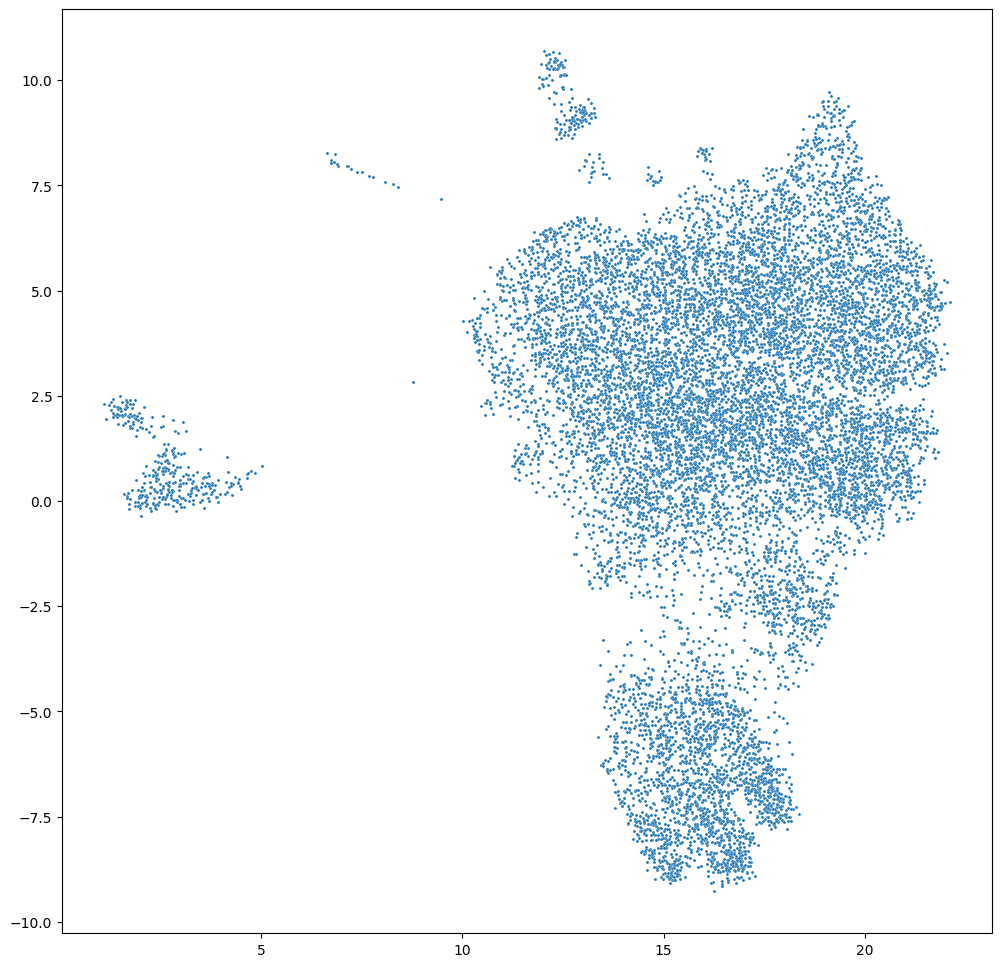

In [60]:
embedding = np.load('data/embedding_plot.npy')

fig, ax = plt.subplots(figsize=(12, 12))
sns.scatterplot(x=embedding.T[0], y=embedding.T[1], s=5, alpha=1)
plt.show()


TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

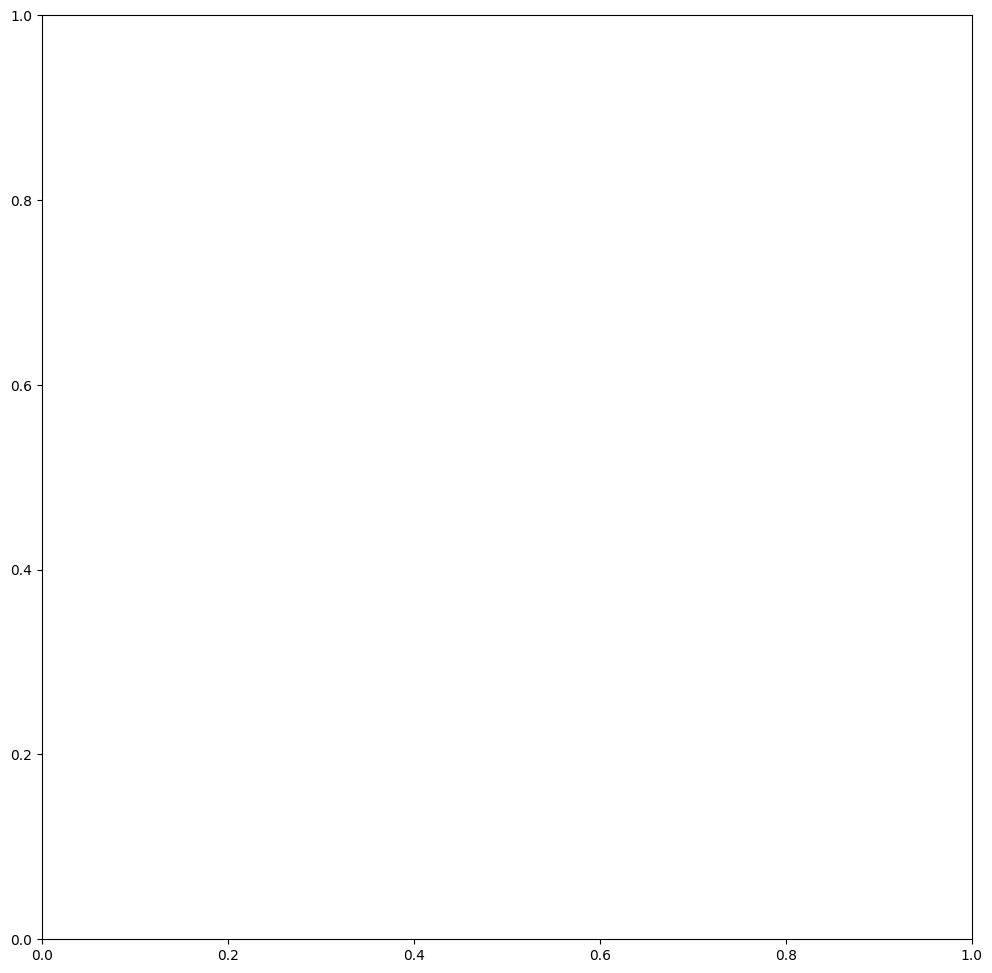

In [59]:
embedding = np.load('data/embedding_plot.npy')

fig, ax = plt.subplots(figsize = (12,12))
sns.scatterplot(*embedding.T, s = 5, alpha = 1)
plt.show()

In [61]:
sns.jointplot(*embedding.T, kind = 'hex', height = 12)
plt.show()

TypeError: jointplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 2 keyword-only arguments) were given

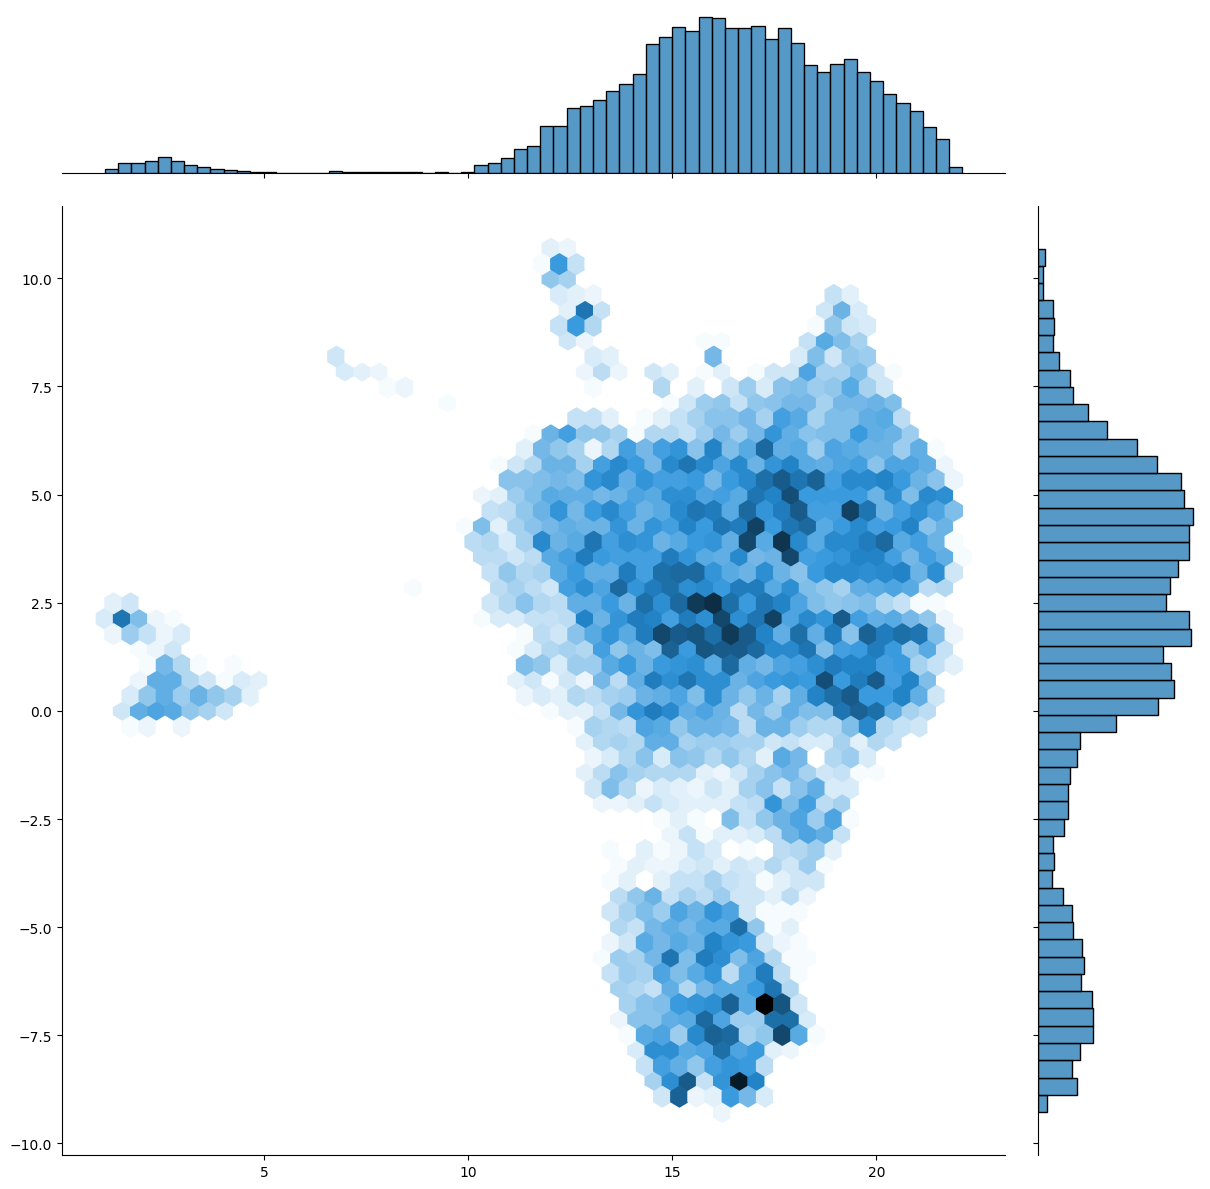

In [62]:
sns.jointplot(x=embedding.T[0], y=embedding.T[1], kind='hex', height=12)
plt.show()


### Finding N-Clusters

In [63]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [58]:
# # stores predicted clustering results
# results=[]
# kmeans_predictions = []

# # iterates for a clustering range of k = 2 to 40
# for k in range(2, 41):
#     kmeans = MiniBatchKMeans(n_clusters=k).fit(sd_pp)
#     predict = kmeans.predict(sd_pp)
#     result = {
#         'k':k,
#         'inertia': kmeans.inertia_,                      # get inertia score for each iteration of k
#         'silhouette': silhouette_score(sd_pp, predict),  # get silhouette score
#     }
#     results.append(result)
#     kmeans_predictions.append(predict)
#     print(result, end='\r')
    
# cluster_results = pd.DataFrame(results)

#### Define cluster size

In [59]:
# cluster_results.to_csv('data/cluster_results')

In [64]:
cluster_results = pd.read_csv('data/cluster_results', index_col= 0)

clusters = 5

#### Plot Inertia

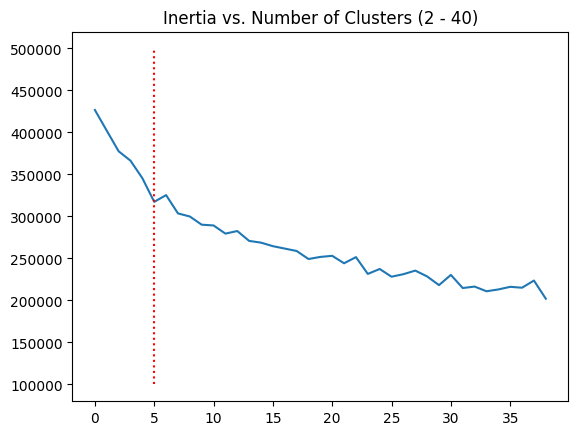

In [65]:
fig, ax = plt.subplots()
ax.set_title('Inertia vs. Number of Clusters (2 - 40)')
cluster_results.inertia.plot(ax=ax)
ax.vlines(x=clusters, ymin=100000, ymax=500000, colors='red', linestyles='dotted')
plt.show()

#### Plot Silohouette Score

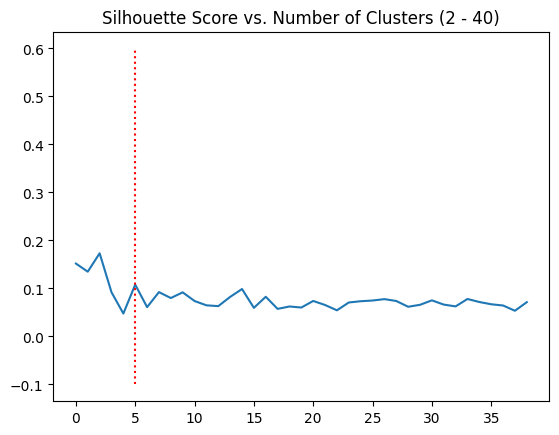

In [66]:
fig, ax = plt.subplots()
ax.set_title('Silhouette Score vs. Number of Clusters (2 - 40)')
cluster_results.silhouette.plot()
ax.vlines(x=clusters, ymin=-.1, ymax=.6, colors='red', linestyles='dotted')
plt.show()

Based on these plots to find the optimum of clusters, we can estimate that the number of clusters is approximately 6 based on the elbow plot above. 

In [67]:
kmeans = MiniBatchKMeans(n_clusters = clusters, random_state = 42).fit(sd_pp)
kmeans

MiniBatchKMeans(n_clusters=5, random_state=42)

In [68]:
# labels for each cluster
pred_labels = np.unique(kmeans.predict(sd_pp))
pred_labels

array([0, 1, 2, 3, 4], dtype=int32)

In [69]:
# get prediction on sd_pp to get labels
sd_cluster_labels = pd.Series(kmeans.predict(sd_pp), index = sd_pp.index)

# convert predicted cluster labels to a list
cluster_list = sd_cluster_labels.values.tolist()

In [70]:
# insert cluster label to the sd_modeling df
sd_clustered = sd_modeling.copy()
sd_clustered.insert(1, 'cluster_label', cluster_list)

sd_clustered.head()

id  cluster_label  latitude  longitude neighbourhood_cleansed  \
0  33159143              1  32.91736 -117.07635          Scripps Ranch   
1  17138468              0  32.84067 -117.27443               La Jolla   
2  21898446              0  32.79797 -117.24250          Pacific Beach   
3  25948680              0  32.77545 -117.05923           College Area   
4   1756516              1  32.84619 -117.27558               La Jolla   

  zipcode property_type        room_type  accommodates  bathrooms  bedrooms  \
0   92131         House     Private room             1        1.0       1.0   
1   92037     Apartment  Entire home/apt             1        2.0       2.0   
2   92109     Townhouse     Private room             1        1.0       1.0   
3   92120     Apartment  Entire home/apt             1        1.0       1.0   
4   92037   Condominium     Private room             1        1.0       1.0   

   beds  bed_type  nightly_price  price_per_stay  security_deposit  \
0     1  Real Bed         1100.0          1100.0            1000.0   
1     3  Real Bed         1400.0          1400.0               0.0   
2     1  Real Bed         1250.0          1250.0               0.0   
3     1  Real Bed         1150.0          1150.0               0.0   
4     1  Real Bed          110.0           110.0             200.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0           0.0              1.0           0.0            60.0   
1           0.0              1.0           0.0            30.0   
2           0.0              1.0           0.0            30.0   
3           0.0              1.0           0.0            31.0   
4           0.0              1.0          50.0           180.0   

   maximum_nights  host_response_time  host_response_rate  host_is_superhost  \
0            90.0  within a few hours               100.0                0.0   
1          1125.0         no response                 0.0                0.0   
2            30.0         no response                 0.0                0.0   
3            40.0         no response                 0.0                0.0   
4           365.0        within a day                67.0                0.0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                   1.0                     0.0   
1                        1.0                   1.0                     0.0   
2                        1.0                   1.0                     0.0   
3                        1.0                   1.0                     0.0   
4                        6.0                   1.0                     1.0   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                0.0              0.0                  98.0   
1                2.0              4.0                 100.0   
2                0.0              0.0                  97.0   
3                0.0              0.0                  98.0   
4                2.0              4.0                  90.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                     7.0                        7.0                    8.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                         10.0                    10.0                 10.0   
4                          8.0                     9.0                 1

In [71]:
# save as csv
path = "data/"

sd_clustered.to_csv(path + 'sd_clustered')

In [72]:
# insert cluster label to the sd_modeling df
sd_pp_clustered = sd_pp.copy()
sd_pp_clustered.insert(0, 'cluster_label', cluster_list)

sd_pp_clustered.head()

cluster_label  Allied Gardens  Alta Vista  Amphitheater And Water Park  \
0              1             0.0         0.0                          0.0   
1              0             0.0         0.0                          0.0   
2              0             0.0         0.0                          0.0   
3              0             0.0         0.0                          0.0   
4              1             0.0         0.0                          0.0   

   Balboa Park  Bario Logan  Bay Ho  Bay Park  Bay Terrace  Bird Land  \
0          0.0          0.0     0.0       0.0          0.0        0.0   
1          0.0          0.0     0.0       0.0          0.0        0.0   
2          0.0          0.0     0.0       0.0          0.0        0.0   
3          0.0          0.0     0.0       0.0          0.0        0.0   
4          0.0          0.0     0.0       0.0          0.0        0.0   

   Bonita Long Canyon  Carmel Mountain  Carmel Valley  Chollas View  \
0                 0.0              0.0            0.0           0.0   
1                 0.0              0.0            0.0           0.0   
2                 0.0              0.0            0.0           0.0   
3                 0.0              0.0            0.0           0.0   
4                 0.0              0.0            0.0           0.0   

   City Heights East  City Heights West  Clairemont Mesa  College Area  \
0                0.0                0.0              0.0           0.0   
1                0.0                0.0              0.0           0.0   
2                0.0                0.0              0.0           0.0   
3                0.0                0.0              0.0           1.0   
4                0.0                0.0              0.0           0.0   

   Columbia  Core  Cortez Hill  Darnall  Del Cerro  Del Mar Heights  \
0       0.0   0.0          0.0      0.0        0.0              0.0   
1       0.0   0.0          0.0      0.0        0.0              0.0   
2       0.0   0.0          0.0      0.0        0.0              0.0   
3       0.0   0.0          0.0      0.0        0.0              0.0   
4       0.0   0.0          0.0      0.0        0.0              0.0   

   East Lake  East Village  Eastlake Trails  Eastlake Vistas  Eastlake Woods  \
0        0.0           0.0              0.0              0.0             0.0   
1        0.0           0.0              0.0              0.0             0.0   
2        0.0           0.0              0.0              0.0             0.0   
3        0.0           0.0              0.0              0.0             0.0   
4        0.0           0.0              0.0              0.0             0.0   

   Egger Highlands  El Cerritos  Emerald Hills  Encanto  Estlake Greens  \
0              0.0          0.0            0.0      0.0             0.0   
1              0.0          0.0            0.0      0.0             0.0   
2              0.0          0.0            0.0      0.0             0.0   
3              0.0          0.0            0.0      0.0             0.0   
4              0.0          0.0            0.0      0.0             0.0   

   Gaslamp Quarter  Gateway  Grant Hill  Grantville  Horton Plaza  \
0              0.0      0.0         0.0         0.0           0.0   
1              0.0      0.0         0.0         0.0           0.0   
2              0.0      0.0         0.0         0.0           0.0   
3              0.0      0.0         0.0         0.0           0.0   
4              0.0      0.0         0.0         0.0           0.0   

   Jomacha-Lomita  Kearny Mesa  Kensington  La Jolla  La Jolla Village  \
0             0.0          0.0         0.0       0.0               0.0   
1             0.0          0.0         0.0       1.0               0.0   
2             0.0          0.0         0.0       0.0               0.0   
3             0.0          0.0         0.0       0.0               0.0   
4             0.0          0.0         0.0       1.0               0.0   

   Lake Mu

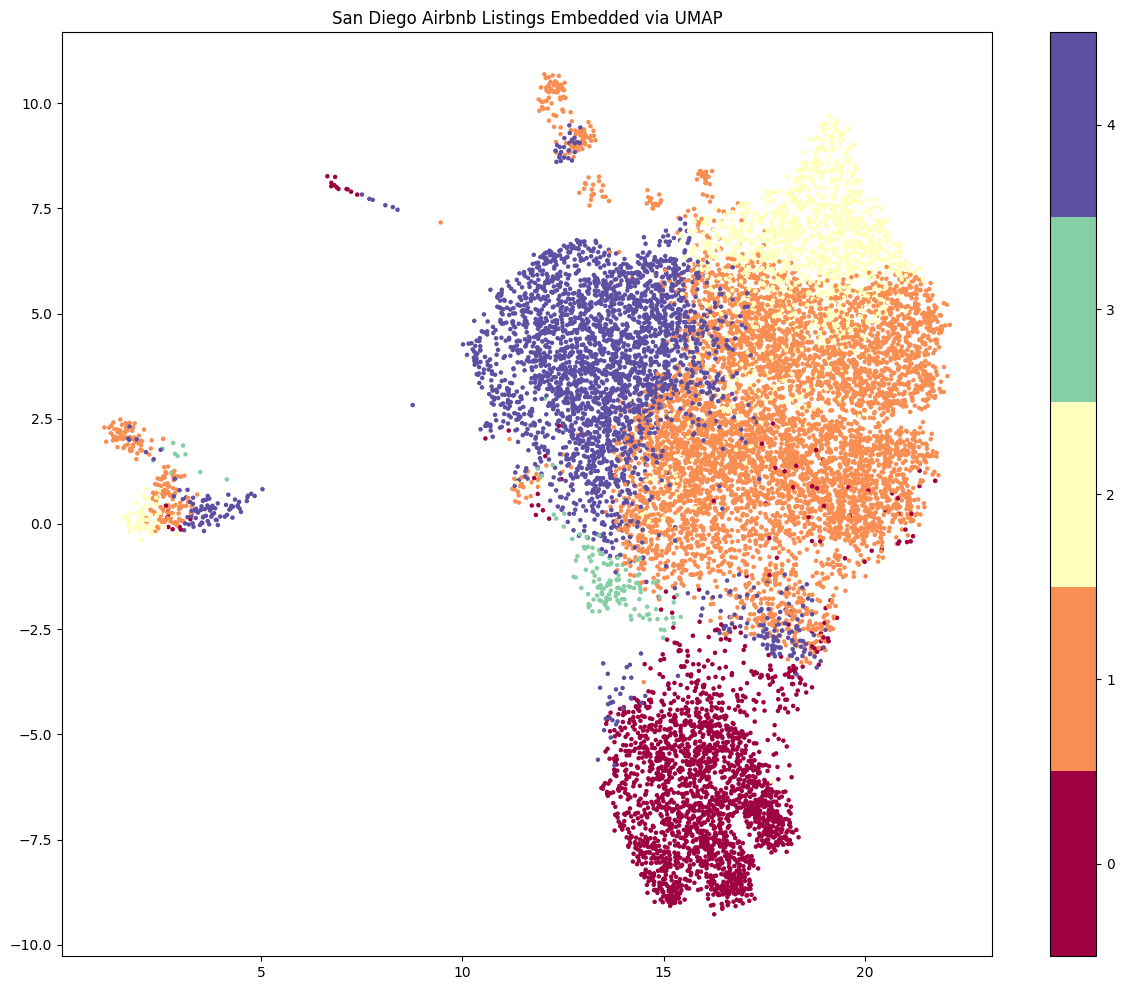

In [73]:
# plot 6 clusters with UMAP 
fig, ax = plt.subplots(figsize = (15,12))

plt.scatter(*embedding.T, s = 5, alpha = 1, c = kmeans.predict(sd_pp), cmap = 'Spectral')

labels = sorted(list(sd_cluster_labels.unique())) # cluster labels

cbar = plt.colorbar(boundaries=np.arange(6)-0.5) # 6 cluster labels
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(labels)
plt.title('San Diego Airbnb Listings Embedded via UMAP');

plt.show()

### Understanding the Cluster Labels with Bokeh

- While we have identified 6 clustered groups/labels, it is still difficult to understand what seperates each individual group from another. I'll now construct an interactive bokeh scatterplot which will assign labels to each point and we'll try to find similarities amongst the clusters. 

In [76]:
from bokeh.resources import INLINE
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap

import bokeh.io

import umap.plot

bokeh.io.output_notebook(INLINE)

Loading BokehJS ...

In [77]:
embedding_map = umap.UMAP(n_neighbors=500, min_dist= .9, random_state=42).fit(sd_pp)

In [78]:
sd_pp_clustered.head(2)

cluster_label  Allied Gardens  Alta Vista  Amphitheater And Water Park  \
0              1             0.0         0.0                          0.0   
1              0             0.0         0.0                          0.0   

   Balboa Park  Bario Logan  Bay Ho  Bay Park  Bay Terrace  Bird Land  \
0          0.0          0.0     0.0       0.0          0.0        0.0   
1          0.0          0.0     0.0       0.0          0.0        0.0   

   Bonita Long Canyon  Carmel Mountain  Carmel Valley  Chollas View  \
0                 0.0              0.0            0.0           0.0   
1                 0.0              0.0            0.0           0.0   

   City Heights East  City Heights West  Clairemont Mesa  College Area  \
0                0.0                0.0              0.0           0.0   
1                0.0                0.0              0.0           0.0   

   Columbia  Core  Cortez Hill  Darnall  Del Cerro  Del Mar Heights  \
0       0.0   0.0          0.0      0.0        0.0              0.0   
1       0.0   0.0          0.0      0.0        0.0              0.0   

   East Lake  East Village  Eastlake Trails  Eastlake Vistas  Eastlake Woods  \
0        0.0           0.0              0.0              0.0             0.0   
1        0.0           0.0              0.0              0.0             0.0   

   Egger Highlands  El Cerritos  Emerald Hills  Encanto  Estlake Greens  \
0              0.0          0.0            0.0      0.0             0.0   
1              0.0          0.0            0.0      0.0             0.0   

   Gaslamp Quarter  Gateway  Grant Hill  Grantville  Horton Plaza  \
0              0.0      0.0         0.0         0.0           0.0   
1              0.0      0.0         0.0         0.0           0.0   

   Jomacha-Lomita  Kearny Mesa  Kensington  La Jolla  La Jolla Village  \
0             0.0          0.0         0.0       0.0               0.0   
1             0.0          0.0         0.0       1.0               0.0   

   Lake Murray  Lincoln Park  Linda Vista  Little Italy  Loma Portal  \
0          0.0           0.0          0.0           0.0          0.0   
1          0.0           0.0          0.0           0.0          0.0   

   Lynwood Hills  Marina  Memorial  Midtown  Midtown District  Mira Mesa  \
0            0.0     0.0       0.0      0.0               0.0        0.0   
1            0.0     0.0       0.0      0.0               0.0        0.0   

   Mission Bay  Mission Valley  Moreno Mission  Mount Hope  Mountain View  \
0          0.0             0.0             0.0         0.0            0.0   
1          0.0             0.0             0.0         0.0            0.0   

   Nestor  Normal Heights  North City  North Clairemont  North Hills  \
0     0.0             0.0         0.0               0.0          0.0   
1     0.0             0.0         0.0               0.0          0.0   

   Northwest  Oak Park  Ocean Beach  Old Town  Otay Ranch  Pacific Beach  \
0        0.0       0.0          0.0       0.0         0.0            0.0   
1        0.0       0.0          0.0       0.0         0.0            0.0   

   Palm City  Paradise Hills  Park West  Paseo Ranchoero  Rancho Bernadino  \
0        0.0             0.0        0.0              0.0               0.0   
1        0.0             0.0        0.0              0.0               0.0   

   Rancho Del Rey  Rancho Penasquitos  Rolando  Rolling Hills Ranch  \
0             0.0                 0.0      0.0                  0.0   
1             0.0                 0.0      0.0                  0.0   

   Roseville  Sabre Springs  San Carlos  San Ysidro  Scripps Ranch  \
0        0.0            0.0         0.0         0.0            1.0   
1        0.0            0.0         0.0         0.0            0.0   

   Serra Mesa  Sky Line  Sorrento Valley  South Park  Southcrest  Southwest  \
0         0.0       0.0              0.0         0.0         0.0        0.0   
1         0.0       0.0              0.0         0.0        

#### Reverse OHE

- In order to make the interactive bokeh plot below more interpretable, I'll need to reverse encode the `sd_pp_clustered` dataframe so that it assigns labels to each individual point in the plot. 


Thus, I'll need to format `sd_pp_clustered` to look like the original column format in `sd_trans` as shown below:

In [79]:
sd_trans.head(2)

neighbourhood_cleansed zipcode property_type        room_type  bed_type  \
0          Scripps Ranch   92131         House     Private room  Real Bed   
1               La Jolla   92037     Apartment  Entire home/apt  Real Bed   

   host_response_time          cancellation_policy  accommodates  bathrooms  \
0  within a few hours  strict_14_with_grace_period             1        1.0   
1         no response  strict_14_with_grace_period             1        2.0   

   bedrooms  beds  nightly_price  price_per_stay  security_deposit  \
0       1.0     1         1100.0          1100.0            1000.0   
1       2.0     3         1400.0          1400.0               0.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0           0.0              1.0           0.0            60.0   
1           0.0              1.0           0.0            30.0   

   maximum_nights  host_response_rate  host_is_superhost  \
0            90.0               100.0                0.0   
1          1125.0                 0.0                0.0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                   1.0                     0.0   
1                        1.0                   1.0                     0.0   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                0.0              0.0                  98.0   
1                2.0              4.0                 100.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   

   requires_license  instant_bookable  is_business_travel_ready  \
0               0.0               1.0                       0.0   
1               0.0               1.0                       0.0   

   require_guest_profile_picture  require_guest_phone_verification  
0                            0.0                               0.0  
1                            0.0                               0.0

In [80]:
# assigns cluster labels
cluster_df = pd.DataFrame(sd_pp_clustered['cluster_label']) 

# assigns neighborhood
neighborhood_df = pd.DataFrame(sd_pp_clustered.loc[:,'Allied Gardens':'Yosemite Dr'].idxmax(axis = 1)).rename(columns = {0:'Neighborhood'})

# assigns property type
property_df = pd.DataFrame(sd_pp_clustered.loc[:,'Aparthotel':'Villa'].idxmax(axis = 1)).rename(columns = {0:'Property'})

# assigns room type
room_df = pd.DataFrame(sd_pp_clustered.loc[:,'Entire home/apt':'Shared room'].idxmax(axis = 1)).rename(columns = {0:'Room Type'})

# assigns price
price = pd.DataFrame('$' + sd_trans['price_per_stay'].astype(str))

# assigns rating
rating = pd.DataFrame(sd_trans['review_scores_rating'].astype(int))


# concat all the dfs
cluster_hover_data = pd.concat([cluster_df, price, rating, neighborhood_df, property_df, room_df], axis = 1)

cluster_hover_data


cluster_label price_per_stay  review_scores_rating   Neighborhood  \
0                  1        $1100.0                    98  Scripps Ranch   
1                  0        $1400.0                   100       La Jolla   
2                  0        $1250.0                    97  Pacific Beach   
3                  0        $1150.0                    98   College Area   
4                  1         $110.0                    90       La Jolla   
...              ...            ...                   ...            ...   
13034              4        $3000.0                    96    Mission Bay   
13035              4        $2823.0                    83       La Jolla   
13036              4         $208.0                    92    Mission Bay   
13037              4        $1305.0                    80       La Jolla   
13038              4         $398.0                    80        Midtown   

          Property        Room Type  
0            House     Private room  
1        Apartment  Entire home/apt  
2        Townhouse     Private room  
3        Apartment  Entire home/apt  
4      Condominium     Private room  
...            ...              ...  
13034        Villa  Entire home/apt  
13035        House  Entire home/apt  
13036        House  Entire home/apt  
13037        House  Entire home/apt  
13038  Condominium  Entire home/apt  

[13039 rows x 6 columns]

In [81]:
embedding_map

UMAP(min_dist=0.9, n_neighbors=500, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [82]:
kmeans.predict(sd_pp)

array([1, 0, 0, ..., 4, 4, 4], dtype=int32)

### Plot Interactive Bokeh Scatterplot with Labels for each Airbnb Listing

In [83]:
p = umap.plot.interactive(embedding_map, 
                          labels = kmeans.predict(sd_pp), # color codes the clusters
                          point_size=5, alpha = 0.3,
                          hover_data=cluster_hover_data, # get cluster labels
                          width = 800, height = 800)
umap.plot.show(p)

### Visualizing the Cluster Groups

In [84]:
# cleaning up columns to plot 
cluster_hover_data['price_per_stay'] = cluster_hover_data['price_per_stay'].str.replace('$', '')
cluster_hover_data['price_per_stay'] = cluster_hover_data['price_per_stay'].astype(float)
cluster_hover_data['cluster_label'] = cluster_hover_data['cluster_label'].astype('category')
cluster_hover_data

cluster_label  price_per_stay  review_scores_rating   Neighborhood  \
0                 1          1100.0                    98  Scripps Ranch   
1                 0          1400.0                   100       La Jolla   
2                 0          1250.0                    97  Pacific Beach   
3                 0          1150.0                    98   College Area   
4                 1           110.0                    90       La Jolla   
...             ...             ...                   ...            ...   
13034             4          3000.0                    96    Mission Bay   
13035             4          2823.0                    83       La Jolla   
13036             4           208.0                    92    Mission Bay   
13037             4          1305.0                    80       La Jolla   
13038             4           398.0                    80        Midtown   

          Property        Room Type  
0            House     Private room  
1        Apartment  Entire home/apt  
2        Townhouse     Private room  
3        Apartment  Entire home/apt  
4      Condominium     Private room  
...            ...              ...  
13034        Villa  Entire home/apt  
13035        House  Entire home/apt  
13036        House  Entire home/apt  
13037        House  Entire home/apt  
13038  Condominium  Entire home/apt  

[13039 rows x 6 columns]

In [85]:
# save as csv
path = "data/"

cluster_hover_data.to_csv(path + 'cluster_hover_data')

#### Distribution of Clusters
Let's first take a look at the distribution of each cluster group. 

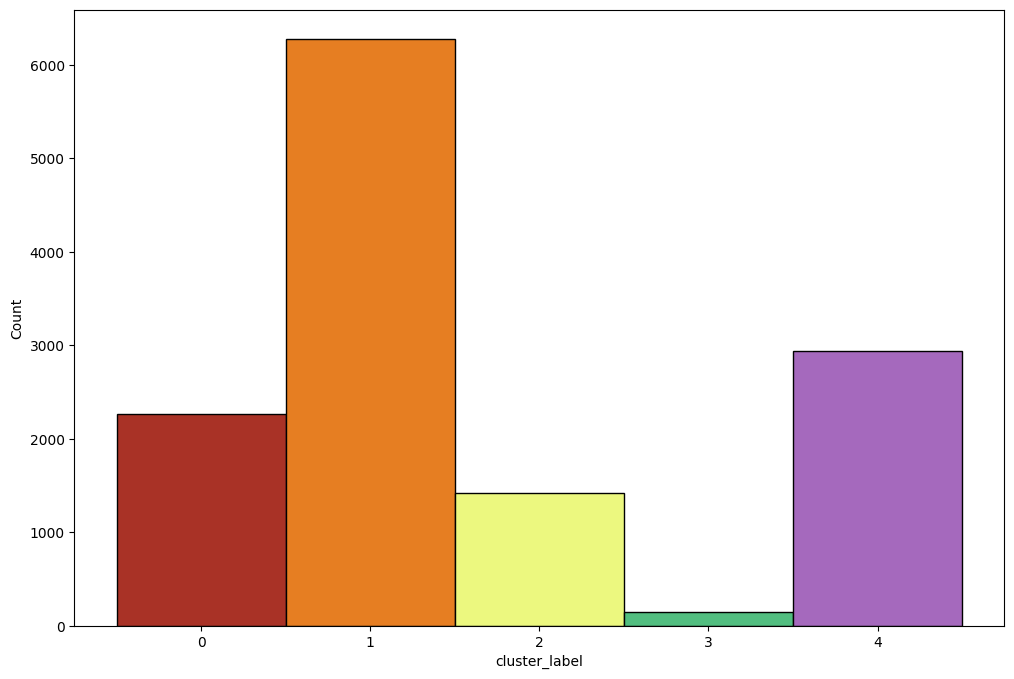

In [86]:
fig, axes = plt.subplots(figsize=(12,8))

ax = sns.histplot(cluster_hover_data['cluster_label'])

# set bar colors
ax.patches[0].set_facecolor('#A93226')
ax.patches[1].set_facecolor('#E67E22')
ax.patches[2].set_facecolor('#ECF87F')
ax.patches[3].set_facecolor('#52BE80')
ax.patches[4].set_facecolor('#A569BD')

plt.show()

In [87]:
# assigning colors to each label
palette = {0: '#A93226', 1:'#E67E22', 2:'#ECF87F', 3:'#52BE80', 4:'#A569BD'}

#### Room Type

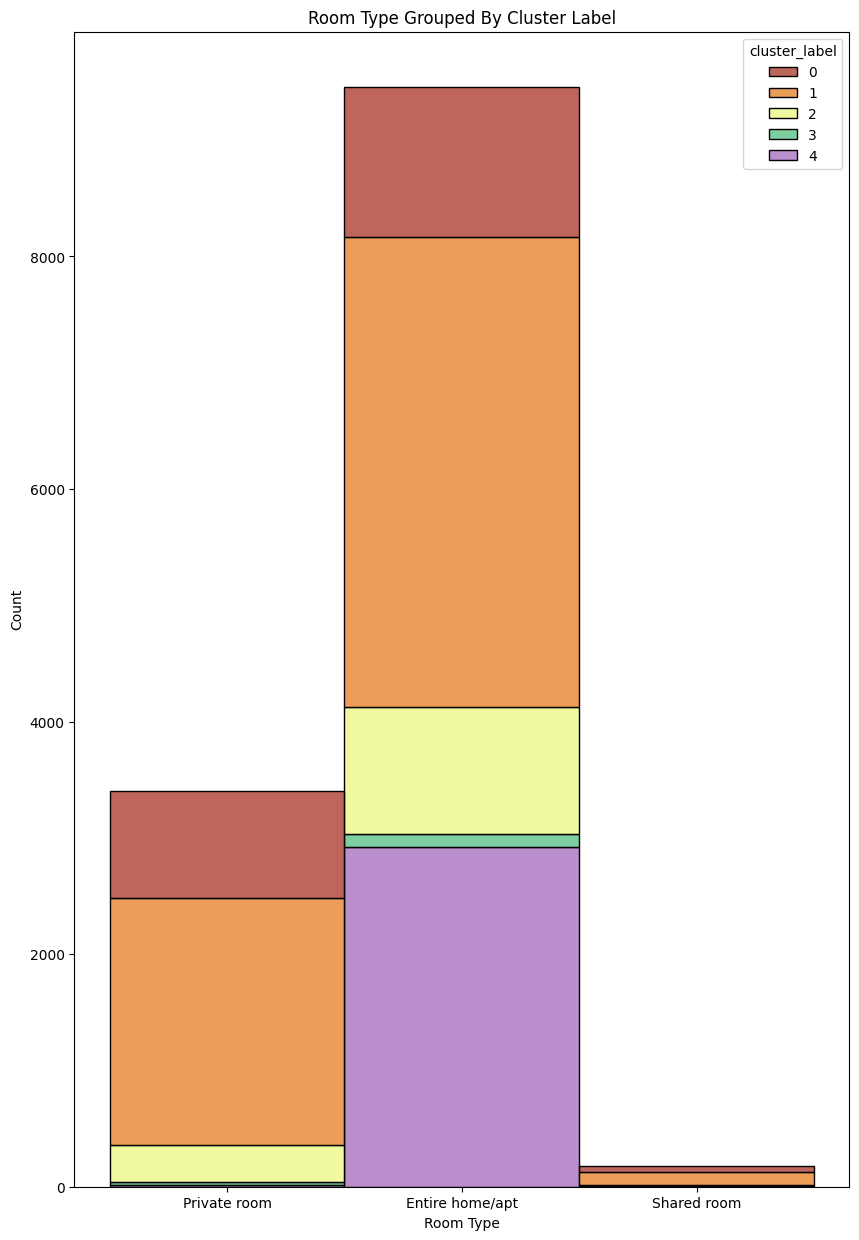

In [88]:
fig, axes = plt.subplots(figsize=(10,15))

ax = sns.histplot(data=cluster_hover_data, 
             x='Room Type', 
             hue='cluster_label', palette = palette,
             multiple="stack").set(title='Room Type Grouped By Cluster Label')

plt.show()

#### Review Score Ratings

**Ratings Above 70**

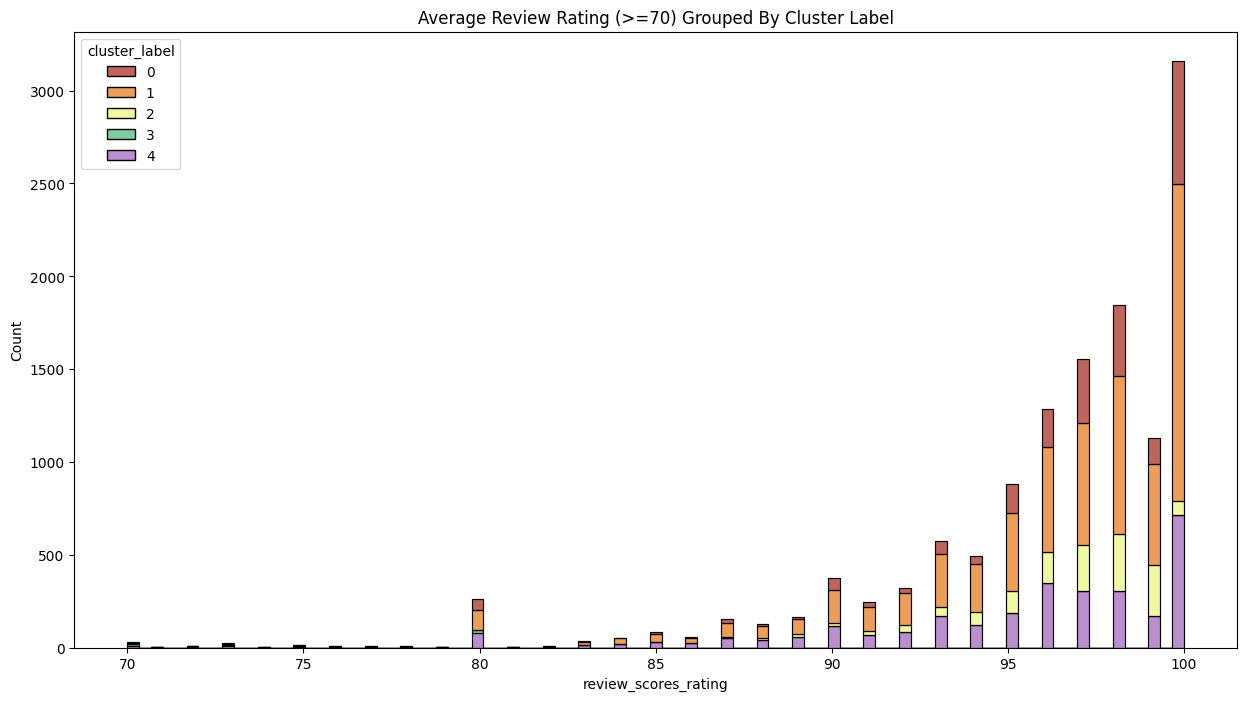

In [89]:
fig, axes = plt.subplots(figsize=(15,8))

# create a filter of greater than 70 rating to remove outliers
greater_than_70 = cluster_hover_data[cluster_hover_data['review_scores_rating'] >= 70]

ax = sns.histplot(data=greater_than_70, 
             x='review_scores_rating', 
             hue='cluster_label', palette = palette,
             multiple="stack").set(title='Average Review Rating (>=70) Grouped By Cluster Label')

plt.show()

**Ratings Below 70**

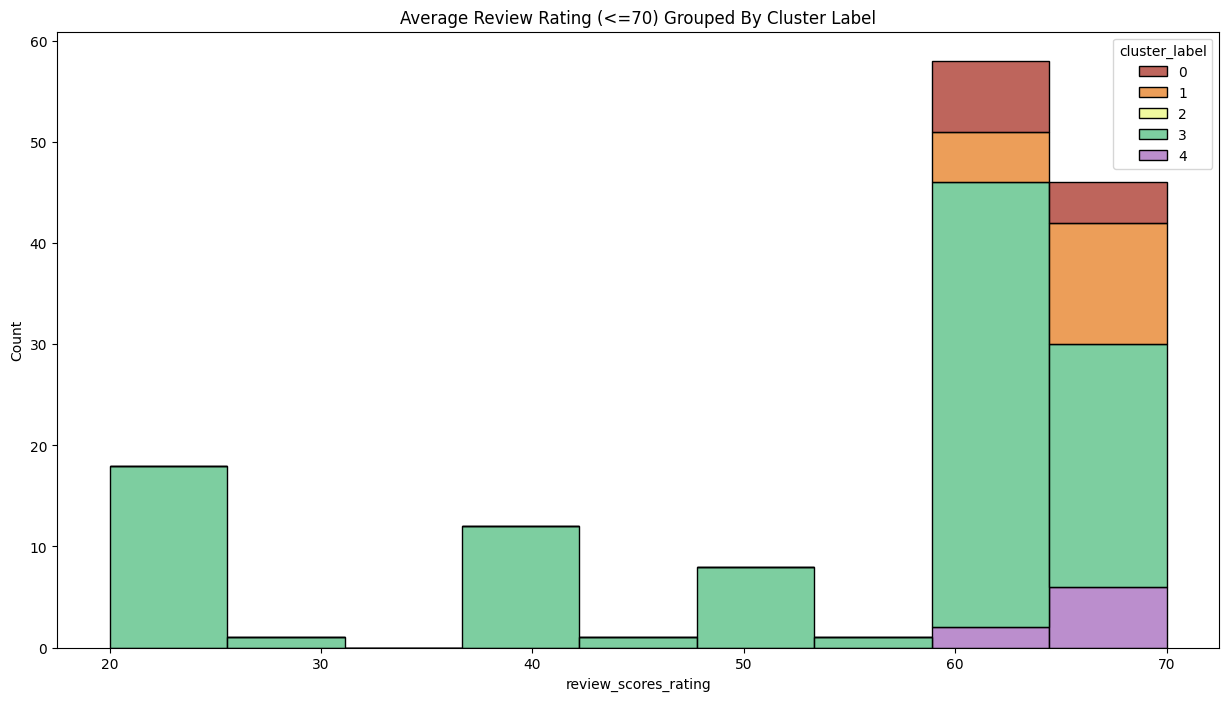

In [90]:
fig, axes = plt.subplots(figsize=(15,8))

# create a filter of LESS than 70 rating to remove outliers
less_than_70 = cluster_hover_data[cluster_hover_data['review_scores_rating'] <= 70]

sns.histplot(data=less_than_70, 
             x='review_scores_rating', 
             hue='cluster_label', palette = palette, 
             multiple="stack").set(title='Average Review Rating (<=70) Grouped By Cluster Label')

plt.show()

#### Price Per Stay

Lets now plot the average price per stay of each cluster label. Since there are so many outliers, we will limit the results to listings less than $1,000. 

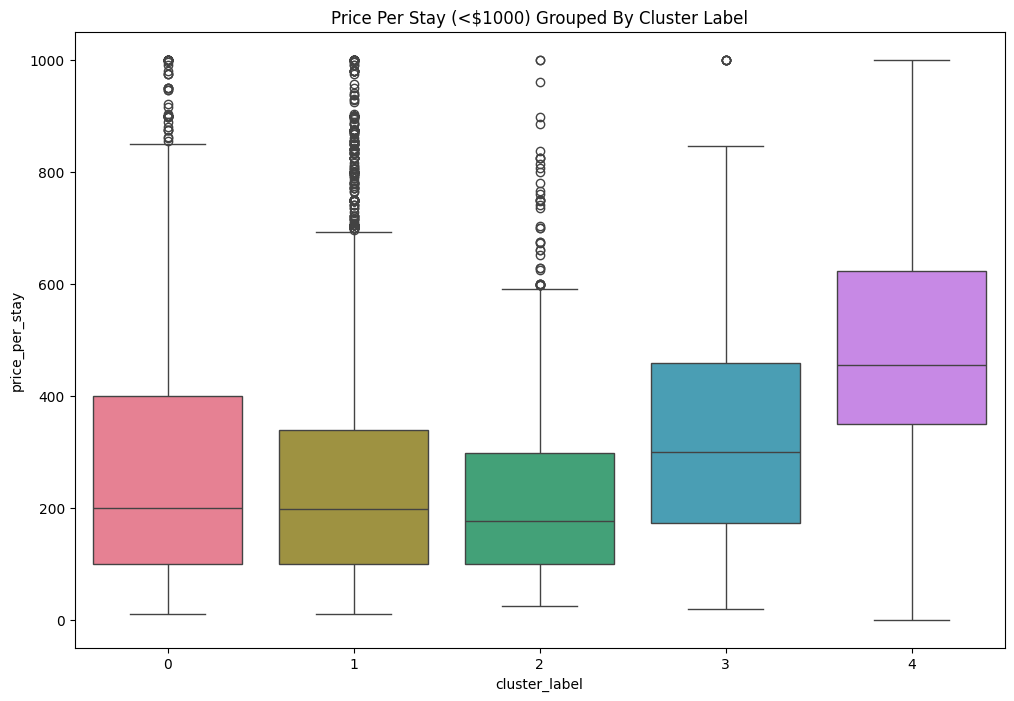

In [92]:
fig, axes = plt.subplots(figsize=(12, 8))

# create a filter of less than $1000 for price per stay to remove outliers
less_than_2000 = cluster_hover_data[cluster_hover_data['price_per_stay'] <= 1000]

# Generate a dynamic palette based on unique values in the 'cluster_label' column
unique_clusters = less_than_2000['cluster_label'].unique()
palette = sns.color_palette("husl", n_colors=len(unique_clusters))

sns.boxplot(
    x=less_than_2000['cluster_label'],
    y=less_than_2000['price_per_stay'],
    palette=palette
).set(title='Price Per Stay (<$1000) Grouped By Cluster Label')

plt.show()


ValueError: The palette dictionary is missing keys: {'3', '4', '0', '2', '1'}

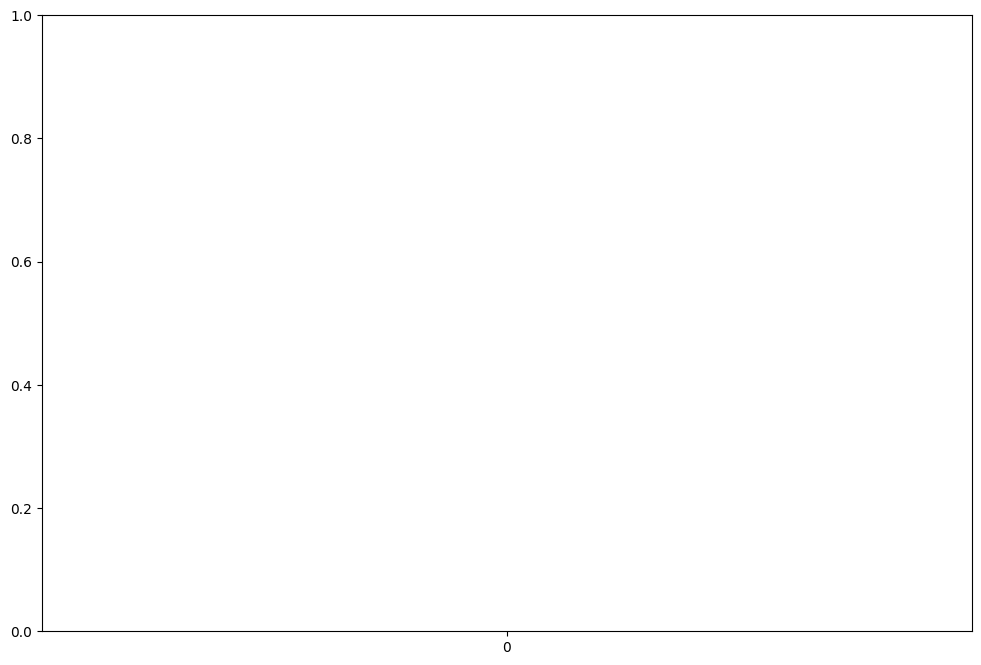

In [91]:
fig, axes = plt.subplots(figsize=(12,8))

# create a filter of less than $1000 for price per stay to remove outliers
less_than_2000 = cluster_hover_data[cluster_hover_data['price_per_stay'] <= 1000]

sns.boxplot(x = less_than_2000['cluster_label'], 
            y = less_than_2000['price_per_stay'], 
            palette = palette).set(title='Price Per Stay (<$1000) Grouped By Cluster Label')

plt.show()

#### Property Types

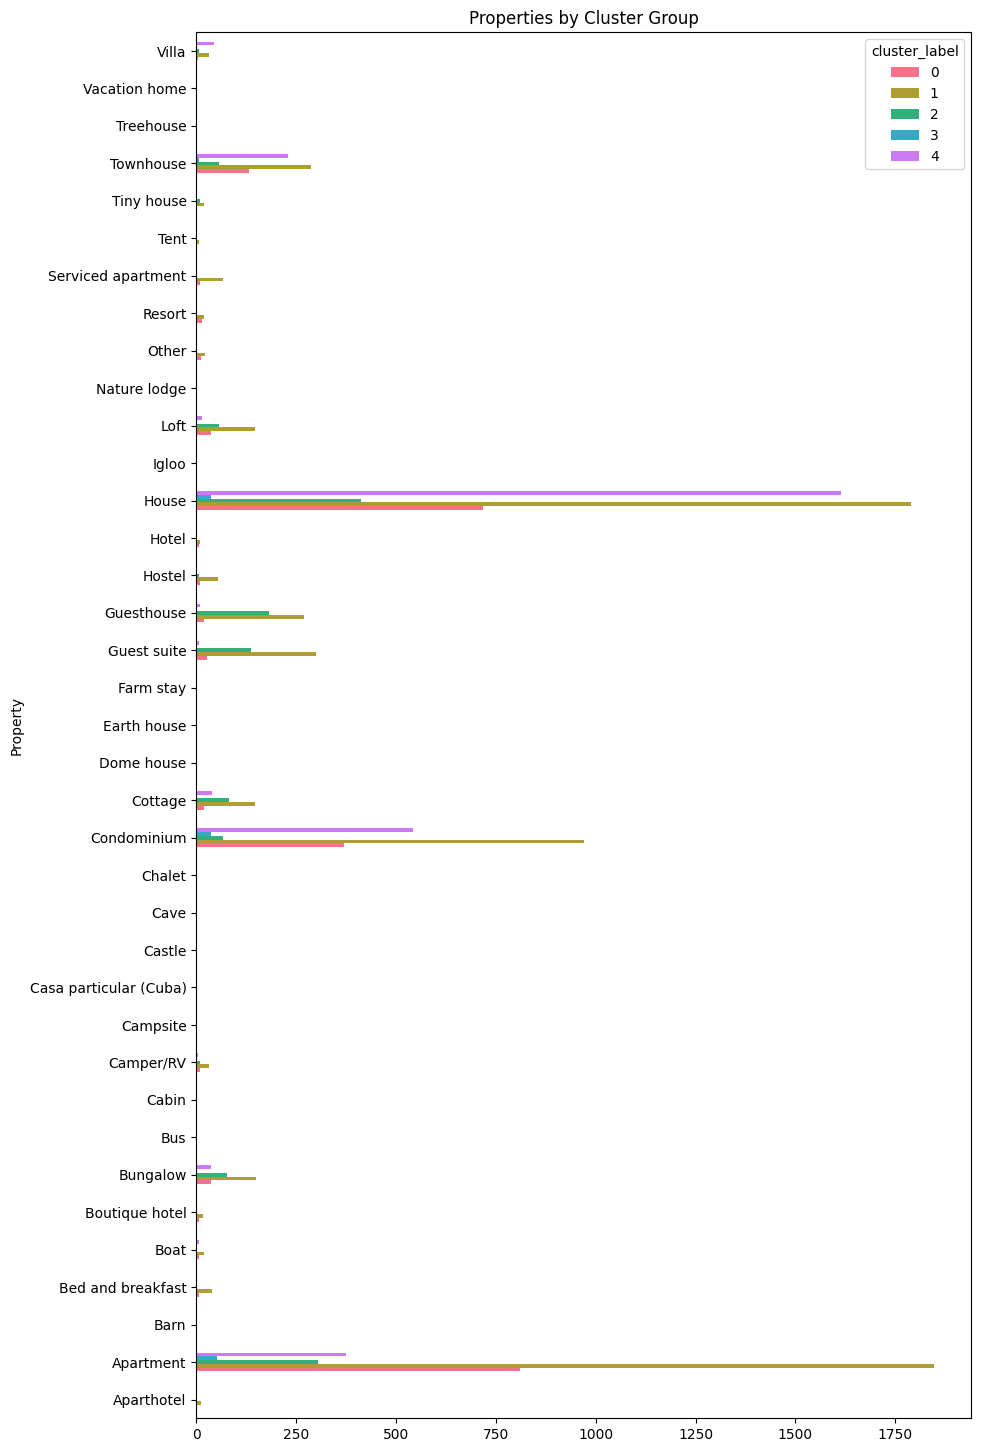

In [93]:
cluster_hover_data.groupby(['Property', 'cluster_label']).size().unstack(fill_value=0).plot.barh(figsize=(10,18), 
                                                                                                 color = palette)

plt.title('Properties by Cluster Group')
plt.show()

### Conclusions About the Clusters

**Cluster Label 0 (Red) - Favorable high end listings**
- Favorable and wide range of review rating. Most expensive listings and mostly consist of entire home room types.
  
**Cluster Label 1 (Orange) - Favorable highly rated & moderately priced listings**
- Popular group, generally > 90 review ratings, relatively inexpensive. Mostly houses or private rooms, wide range of property types.
  
**Cluster Label 2 (Yellow) - Favorable moderately priced diverse listings**
- Most popular group, mostly favorable ratings. Relatively low priced. Wide range of property types.
  
**Cluster Label 3 (Green) - Favorable and least expensive listings**
- Popular group and wide range of review rating. Least expensive group. Wide range of property types.
  
**Cluster Label 4 (Purple) - Unfavorable listings**
- Least popular group and lowest rated listings.
